In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [2]:
import os  # Add this line at the beginning of your code

save_dir = '/kaggle/working/'  # Specify your directory path
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [3]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Paths to the dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata CSV
labels = pd.read_csv(metadata_file)

# Convert diagnosis (dx) to integers (you can map specific diseases if needed)
label_mapping = {label: idx for idx, label in enumerate(labels['dx'].unique())}
labels['dx'] = labels['dx'].map(label_mapping)

# Set image size for the model
IMG_SIZE = 28  # Resize images to 28x28

# Function to load and preprocess images
def load_images_and_labels(labels, image_dir_1, image_dir_2, img_size=28):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        # Get the file path for the image
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        # Check if the image exists in part 1 or part 2
        if os.path.exists(file_path_1):
            img = image.load_img(file_path_1, target_size=(img_size, img_size))
        elif os.path.exists(file_path_2):
            img = image.load_img(file_path_2, target_size=(img_size, img_size))
        else:
            continue  # Skip if image file is missing

        # Convert image to numpy array and normalize it
        img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
        label_list.append(row['dx'])  # Add the label (dx)

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = np.array(label_list)  # Labels: [0, 1, 2, ..., 6] for classification
    return X, y

# Load the images and labels
X, y = load_images_and_labels(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Step 1: Split into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Split the 80% training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Check the shape of the dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=7)  # Assuming 7 classes
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=7)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=7)

# Compute class weights to handle class imbalance
def compute_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(labels), y=labels
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weight_dict

class_weights = compute_class_weights(y_train)

# Data Augmentation for the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creating data pipeline for training and validation
train_dataset = train_datagen.flow(X_train, y_train_one_hot, batch_size=16)
val_dataset = val_datagen.flow(X_val, y_val_one_hot, batch_size=16)

# Efficient data pipeline: cache, batch, and prefetch (for training and validation datasets)
def create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size):
    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

    # Efficient data pipeline: cache, batch, and prefetch
    train_data = (train_data
                  .cache()
                  .shuffle(buffer_size=1000)
                  .batch(batch_size)
                  .prefetch(tf.data.experimental.AUTOTUNE))
    
    val_data = (val_data
                .cache()
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

    test_data = (test_data
                 .cache()
                 .batch(batch_size)
                 .prefetch(tf.data.experimental.AUTOTUNE))

    return train_data, val_data, test_data

# Set batch size for training
batch_size = 32

# Create the dataset pipeline for efficient data loading
train_data, val_data, test_data = create_dataset(X_train, y_train_one_hot, X_val, y_val_one_hot, X_test, y_test_one_hot, batch_size)


Training set shape: (5608, 28, 28, 3)
Validation set shape: (2404, 28, 28, 3)
Test set shape: (2003, 28, 28, 3)


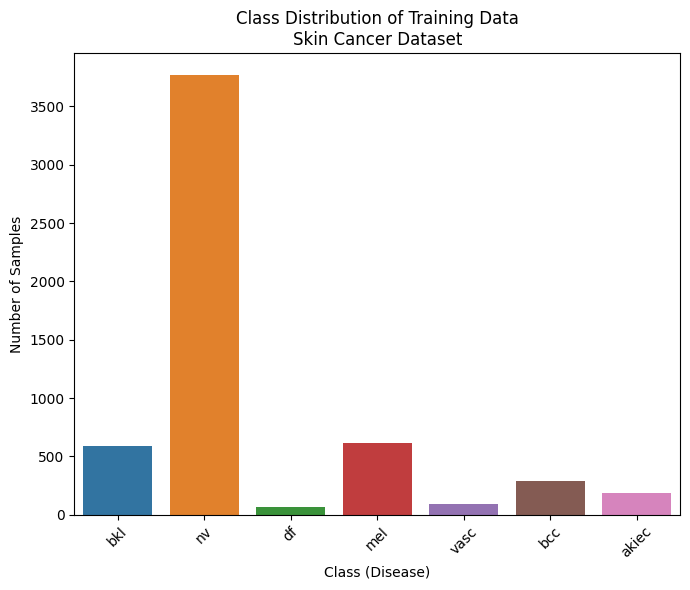

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add disease names for better interpretation
disease_labels = {v: k for k, v in label_mapping.items()}

# Update the plot function to show disease names on the x-axis
def plot_class_distribution(y_original, title, disease_labels):
    y_original_series = pd.Series(y_original)
    
    original_class_dist = y_original_series.value_counts().sort_index()
    
    # Plot the class distribution
    plt.figure(figsize=(7, 6))
    sns.barplot(x=original_class_dist.index, y=original_class_dist.values)
    plt.title(f'Class Distribution of Training Data\n{title}')
    plt.xlabel('Class (Disease)')
    plt.ylabel('Number of Samples')
    plt.xticks(ticks=original_class_dist.index, labels=[disease_labels.get(i, i) for i in original_class_dist.index], rotation=45)
    plt.tight_layout()
    plt.show()

# Call the updated function to plot the class distribution of the original training data
plot_class_distribution(y_train, 'Skin Cancer Dataset', disease_labels)


Random Image from Training Data:


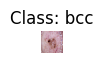

In [6]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to display a random image from the dataset
def display_random_image(X, y, labels, img_size=28):
    # Pick a random index
    random_index = random.randint(0, len(X) - 1)
    
    # Get the image and its corresponding label
    random_img = X[random_index]
    random_label = y[random_index]
    
    # Convert image array back to displayable format (no resizing)
    random_img_display = image.array_to_img(random_img)
    
    # Get the actual image dimensions
    img_height, img_width, _ = random_img.shape
    
    # Set the figure size based on the actual image size (in inches)
    # Convert pixels to inches (assuming 100 dpi by default)
    figsize = (img_width / 100, img_height / 100)
    
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    plt.imshow(random_img_display)
    plt.title(f"Class: {labels[random_label]}")
    plt.axis('off')  # Hide axes for better clarity
    plt.show()

# Display a random image from the original dataset
def visualize_random_image(X_train, y_train, labels_reverse, img_size=28):
    print("Random Image from Training Data:")
    display_random_image(X_train, y_train, labels_reverse, img_size)

# Convert label back to its original class name using the 'label_mapping'
labels_reverse = {v: k for k, v in label_mapping.items()}  # Reverse the label mapping

# Visualize a random image from the original training data at actual size
visualize_random_image(X_train, y_train, labels_reverse, img_size=28)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

latent_dim = 128  # Latent dimension (size of the compressed representation)

# Encoder (Updated with reduced filters, depthwise separable convolutions, and batch normalization)
encoder = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.SeparableConv2D(16, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (28, 28) -> (14, 14, 16)
    layers.BatchNormalization(),
    
    layers.SeparableConv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", depth_multiplier=1),  # (14, 14) -> (7, 7, 32)
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation (128)
])

# Decoder (Updated to output 28x28 with 'same' padding, using depthwise separable convolutions)
decoder = tf.keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(7 * 7 * 32, activation="relu"),  # Upscale to match the desired dimensions
    layers.Reshape((7, 7, 32)),  # Shape after first dense layer
    layers.BatchNormalization(),
    
    layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation='relu'),  # (14, 14, 32)
    layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation='relu'),  # (28, 28, 16)
    layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='sigmoid'),  # (28, 28, 3)
])

# Full autoencoder model
autoencoder_input = layers.Input(shape=(28, 28, 3))  # Changed input shape to (28, 28, 3)
latent_representation = encoder(autoencoder_input)
reconstructed_image = decoder(latent_representation)

autoencoder = models.Model(inputs=autoencoder_input, outputs=reconstructed_image)

# Compile the autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Print model summary to check the architecture
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128)                 │         201,803 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28, 3)           │         216,707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,510 (1.60 MB)

 Trainable params: 418,350 (1.60 MB)

 Non-trainable params: 160 (640.00 B)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_discriminator(input_shape=(28, 28, 3), num_classes=7):
    model = models.Sequential()

    # First convolutional layer with 16 filters and 'same' padding
    model.add(layers.Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    
    # Second convolutional layer with 32 filters and 'valid' padding (matches provided output)
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))  # (28, 28) -> (26, 26)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (26, 26) -> (13, 13)
    model.add(layers.BatchNormalization())
    
    # Third convolutional layer with 32 filters and 'same' padding
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))  # (13, 13) -> (13, 13)

    # Fourth convolutional layer with 64 filters and 'valid' padding
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))  # (13, 13) -> (11, 11)
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # (11, 11) -> (6, 6)
    model.add(layers.BatchNormalization())
    
    # Flatten the feature maps
    model.add(layers.Flatten())  # (6, 6, 64) -> 2304

    # Dense layer (fully connected) with 64 units
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Fully connected (dense) layer with 32 units
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    # Output layer with Softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output 7 classes
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the discriminator model
num_classes = 7  # Number of classes in the dataset (e.g., 7 for HAM10000 dataset)
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=num_classes)

# Display the model summary
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,055 (539.28 KB)

 Trainable params: 137,831 (538.40 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm

# Assuming you have an autoencoder model that is already trained
# Use the decoder part of the autoencoder as the generator
generator = autoencoder.layers[-2]  # Decoder of the autoencoder
discriminator = create_discriminator(input_shape=(28, 28, 3), num_classes=7)

# Define the GAN model
def create_gan(generator, discriminator, latent_dim=128):
    # Freeze the discriminator during the generator training
    discriminator.trainable = False

    # Input layer for random noise (latent vector of size 128)
    gan_input = layers.Input(shape=(latent_dim,))
    
    # Use the generator (autoencoder's decoder) to generate images
    x = generator(gan_input)  # Generator generates fake images
    gan_output = discriminator(x)  # Discriminator evaluates the fake image

    # Build the GAN model
    gan = models.Model(gan_input, gan_output)
    
    # Compile the GAN with categorical cross-entropy loss for multi-class classification
    gan.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    return gan

# Loss functions for the autoencoder and discriminator
loss_fn_auto = tf.keras.losses.MeanSquaredError()  # For the autoencoder (reconstruction loss)
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # For discriminator (classification loss)

# Optimizers for autoencoder and discriminator
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Metrics to store losses and accuracies for tracking
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop for GAN
for epoch in range(300):
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_data)):
        with tf.GradientTape(persistent=True) as tape:
            # Pass batch through the encoder and decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Pass batch through the discriminator (real vs fake image)
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients to autoencoder
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        # Apply gradients to discriminator
        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop
    for val_batch_real, val_batch_label in val_data:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics
    print(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")


100%|██████████| 176/176 [00:51<00:00,  3.45it/s]


Epoch 0, Autoencoder Loss: 0.03373761847615242, Discriminator Loss: 1.3040639162063599, Discriminator Accuracy: 0.6589133739471436
Validation - Autoencoder Loss: 0.021866561844944954, Discriminator Loss: 1.1447962522506714, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 1, Autoencoder Loss: 0.020669300109148026, Discriminator Loss: 1.1157169342041016, Discriminator Accuracy: 0.6711647510528564
Validation - Autoencoder Loss: 0.020009174942970276, Discriminator Loss: 1.0963226556777954, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 2, Autoencoder Loss: 0.01851481944322586, Discriminator Loss: 1.0942023992538452, Discriminator Accuracy: 0.6722301244735718
Validation - Autoencoder Loss: 0.016981275752186775, Discriminator Loss: 1.094965934753418, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 3, Autoencoder Loss: 0.01305054035037756, Discriminator Loss: 1.0437475442886353, Discriminator Accuracy: 0.6732954382896423
Validation - Autoencoder Loss: 0.010902567766606808, Discriminator Loss: 1.029036045074463, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 4, Autoencoder Loss: 0.009675642475485802, Discriminator Loss: 1.0175395011901855, Discriminator Accuracy: 0.6716974377632141
Validation - Autoencoder Loss: 0.00898178480565548, Discriminator Loss: 1.0094894170761108, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 5, Autoencoder Loss: 0.008243700489401817, Discriminator Loss: 1.0003979206085205, Discriminator Accuracy: 0.6711647510528564
Validation - Autoencoder Loss: 0.007789538241922855, Discriminator Loss: 0.9875407218933105, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 6, Autoencoder Loss: 0.007001334801316261, Discriminator Loss: 0.9769629836082458, Discriminator Accuracy: 0.6727628111839294
Validation - Autoencoder Loss: 0.00667296489700675, Discriminator Loss: 0.9967283010482788, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 7, Autoencoder Loss: 0.0060832989402115345, Discriminator Loss: 0.9599422216415405, Discriminator Accuracy: 0.6709871888160706
Validation - Autoencoder Loss: 0.005910626612603664, Discriminator Loss: 0.9508527517318726, Discriminator Accuracy: 0.6632401347160339


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 8, Autoencoder Loss: 0.005495906341820955, Discriminator Loss: 0.9440785050392151, Discriminator Accuracy: 0.6725852489471436
Validation - Autoencoder Loss: 0.005470793694257736, Discriminator Loss: 0.9389793276786804, Discriminator Accuracy: 0.6661184430122375


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 9, Autoencoder Loss: 0.005144861526787281, Discriminator Loss: 0.927814245223999, Discriminator Accuracy: 0.6750710010528564
Validation - Autoencoder Loss: 0.005189703777432442, Discriminator Loss: 0.9275159239768982, Discriminator Accuracy: 0.6657072305679321


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 10, Autoencoder Loss: 0.004898824263364077, Discriminator Loss: 0.9151583313941956, Discriminator Accuracy: 0.6745383739471436
Validation - Autoencoder Loss: 0.004962142091244459, Discriminator Loss: 0.9134819507598877, Discriminator Accuracy: 0.6702302694320679


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 11, Autoencoder Loss: 0.004686771892011166, Discriminator Loss: 0.9026866555213928, Discriminator Accuracy: 0.6782670617103577
Validation - Autoencoder Loss: 0.004760830197483301, Discriminator Loss: 0.9248598217964172, Discriminator Accuracy: 0.6710526347160339


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 12, Autoencoder Loss: 0.004520639311522245, Discriminator Loss: 0.8910169005393982, Discriminator Accuracy: 0.6786221861839294
Validation - Autoencoder Loss: 0.004594959318637848, Discriminator Loss: 0.8920659422874451, Discriminator Accuracy: 0.6747533082962036


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 13, Autoencoder Loss: 0.0043644532561302185, Discriminator Loss: 0.8800069689750671, Discriminator Accuracy: 0.6786221861839294
Validation - Autoencoder Loss: 0.004475854802876711, Discriminator Loss: 0.8810317516326904, Discriminator Accuracy: 0.6796875


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 14, Autoencoder Loss: 0.004240859765559435, Discriminator Loss: 0.867947518825531, Discriminator Accuracy: 0.6853693127632141
Validation - Autoencoder Loss: 0.004362244158983231, Discriminator Loss: 0.8755062222480774, Discriminator Accuracy: 0.6817434430122375


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 15, Autoencoder Loss: 0.004127879627048969, Discriminator Loss: 0.865905225276947, Discriminator Accuracy: 0.6834161877632141
Validation - Autoencoder Loss: 0.004243697039783001, Discriminator Loss: 0.871249258518219, Discriminator Accuracy: 0.6821545958518982


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 16, Autoencoder Loss: 0.004016096703708172, Discriminator Loss: 0.8541072607040405, Discriminator Accuracy: 0.6843039989471436
Validation - Autoencoder Loss: 0.004120555240660906, Discriminator Loss: 0.856274425983429, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 17, Autoencoder Loss: 0.003916327841579914, Discriminator Loss: 0.8459451198577881, Discriminator Accuracy: 0.6866121888160706
Validation - Autoencoder Loss: 0.004051102790981531, Discriminator Loss: 0.8704986572265625, Discriminator Accuracy: 0.6788651347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 18, Autoencoder Loss: 0.003814529627561569, Discriminator Loss: 0.8335068225860596, Discriminator Accuracy: 0.6908735632896423
Validation - Autoencoder Loss: 0.00393653055652976, Discriminator Loss: 0.8508168458938599, Discriminator Accuracy: 0.6833881735801697


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 19, Autoencoder Loss: 0.0037296435330063105, Discriminator Loss: 0.8282806873321533, Discriminator Accuracy: 0.6928266882896423
Validation - Autoencoder Loss: 0.003874929388985038, Discriminator Loss: 0.8549819588661194, Discriminator Accuracy: 0.6792762875556946


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 20, Autoencoder Loss: 0.003657802240923047, Discriminator Loss: 0.8228902816772461, Discriminator Accuracy: 0.6953125
Validation - Autoencoder Loss: 0.0038076271302998066, Discriminator Loss: 0.8403511047363281, Discriminator Accuracy: 0.6891447305679321


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 21, Autoencoder Loss: 0.003591624554246664, Discriminator Loss: 0.8174534440040588, Discriminator Accuracy: 0.6956676244735718
Validation - Autoencoder Loss: 0.0037237389478832483, Discriminator Loss: 0.8365168571472168, Discriminator Accuracy: 0.6944901347160339


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 22, Autoencoder Loss: 0.0035218121483922005, Discriminator Loss: 0.8157249689102173, Discriminator Accuracy: 0.6976207494735718
Validation - Autoencoder Loss: 0.003659958951175213, Discriminator Loss: 0.8307957649230957, Discriminator Accuracy: 0.6875


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 23, Autoencoder Loss: 0.0034766895696520805, Discriminator Loss: 0.8053674101829529, Discriminator Accuracy: 0.7054332494735718
Validation - Autoencoder Loss: 0.00364202493801713, Discriminator Loss: 0.8269827961921692, Discriminator Accuracy: 0.6879112124443054


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 24, Autoencoder Loss: 0.0034216702915728092, Discriminator Loss: 0.8045142889022827, Discriminator Accuracy: 0.697265625
Validation - Autoencoder Loss: 0.003566908184438944, Discriminator Loss: 0.826499342918396, Discriminator Accuracy: 0.6895559430122375


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 25, Autoencoder Loss: 0.0033802776597440243, Discriminator Loss: 0.8000549077987671, Discriminator Accuracy: 0.701171875
Validation - Autoencoder Loss: 0.0035259677097201347, Discriminator Loss: 0.8193925023078918, Discriminator Accuracy: 0.6957237124443054


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 26, Autoencoder Loss: 0.0033255107700824738, Discriminator Loss: 0.8022768497467041, Discriminator Accuracy: 0.7043678760528564
Validation - Autoencoder Loss: 0.003470053430646658, Discriminator Loss: 0.8184502124786377, Discriminator Accuracy: 0.6969572305679321


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 27, Autoencoder Loss: 0.0032816596794873476, Discriminator Loss: 0.793397843837738, Discriminator Accuracy: 0.7013494372367859
Validation - Autoencoder Loss: 0.0034499610774219036, Discriminator Loss: 0.8240798711776733, Discriminator Accuracy: 0.6953125


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 28, Autoencoder Loss: 0.00325587741099298, Discriminator Loss: 0.7880665063858032, Discriminator Accuracy: 0.7034801244735718
Validation - Autoencoder Loss: 0.003416965948417783, Discriminator Loss: 0.8363499641418457, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 29, Autoencoder Loss: 0.003205677028745413, Discriminator Loss: 0.7881009578704834, Discriminator Accuracy: 0.7068536877632141
Validation - Autoencoder Loss: 0.003370336489751935, Discriminator Loss: 0.8077206611633301, Discriminator Accuracy: 0.6986019611358643


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 30, Autoencoder Loss: 0.0031744411680847406, Discriminator Loss: 0.7786792516708374, Discriminator Accuracy: 0.7073863744735718
Validation - Autoencoder Loss: 0.0033151116222143173, Discriminator Loss: 0.8049463033676147, Discriminator Accuracy: 0.6994243264198303


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 31, Autoencoder Loss: 0.0031412222888320684, Discriminator Loss: 0.7732862234115601, Discriminator Accuracy: 0.7086292505264282
Validation - Autoencoder Loss: 0.003292448353022337, Discriminator Loss: 0.8004275560379028, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 32, Autoencoder Loss: 0.00310003524646163, Discriminator Loss: 0.7695055603981018, Discriminator Accuracy: 0.7063210010528564
Validation - Autoencoder Loss: 0.0032579742837697268, Discriminator Loss: 0.8138471841812134, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 33, Autoencoder Loss: 0.003074070904403925, Discriminator Loss: 0.7678998708724976, Discriminator Accuracy: 0.7036576867103577
Validation - Autoencoder Loss: 0.0032329638488590717, Discriminator Loss: 0.8279807567596436, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 34, Autoencoder Loss: 0.003040800802409649, Discriminator Loss: 0.765755295753479, Discriminator Accuracy: 0.7040128111839294
Validation - Autoencoder Loss: 0.0031956871971488, Discriminator Loss: 0.8116063475608826, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 35, Autoencoder Loss: 0.0030126094352453947, Discriminator Loss: 0.7600318789482117, Discriminator Accuracy: 0.7088068127632141
Validation - Autoencoder Loss: 0.0031662951223552227, Discriminator Loss: 0.7962720394134521, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 36, Autoencoder Loss: 0.0029804096557199955, Discriminator Loss: 0.7604213953018188, Discriminator Accuracy: 0.7086292505264282
Validation - Autoencoder Loss: 0.0031385181937366724, Discriminator Loss: 0.7952138781547546, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 37, Autoencoder Loss: 0.002964021172374487, Discriminator Loss: 0.753582775592804, Discriminator Accuracy: 0.7075639367103577
Validation - Autoencoder Loss: 0.0031301616691052914, Discriminator Loss: 0.7886258959770203, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 38, Autoencoder Loss: 0.0029258406721055508, Discriminator Loss: 0.7449720501899719, Discriminator Accuracy: 0.7111150622367859
Validation - Autoencoder Loss: 0.0030742036178708076, Discriminator Loss: 0.7926411032676697, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 39, Autoencoder Loss: 0.0029006802942603827, Discriminator Loss: 0.7475596070289612, Discriminator Accuracy: 0.7144886255264282
Validation - Autoencoder Loss: 0.003060475457459688, Discriminator Loss: 0.7951375842094421, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 40, Autoencoder Loss: 0.002877479186281562, Discriminator Loss: 0.7441311478614807, Discriminator Accuracy: 0.7116477489471436
Validation - Autoencoder Loss: 0.003066029865294695, Discriminator Loss: 0.8005524277687073, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 41, Autoencoder Loss: 0.0028465702198445797, Discriminator Loss: 0.7429599761962891, Discriminator Accuracy: 0.7155539989471436
Validation - Autoencoder Loss: 0.0030087456107139587, Discriminator Loss: 0.7842276692390442, Discriminator Accuracy: 0.7080591917037964


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 42, Autoencoder Loss: 0.002827271120622754, Discriminator Loss: 0.7338870763778687, Discriminator Accuracy: 0.7151988744735718
Validation - Autoencoder Loss: 0.0029863195959478617, Discriminator Loss: 0.7910601496696472, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 43, Autoencoder Loss: 0.00280293682590127, Discriminator Loss: 0.7389099597930908, Discriminator Accuracy: 0.7143110632896423
Validation - Autoencoder Loss: 0.0029598057735711336, Discriminator Loss: 0.7770077586174011, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 44, Autoencoder Loss: 0.002793447347357869, Discriminator Loss: 0.7297791838645935, Discriminator Accuracy: 0.7137784361839294
Validation - Autoencoder Loss: 0.0029963229317218065, Discriminator Loss: 0.7916074395179749, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 45, Autoencoder Loss: 0.0027629435062408447, Discriminator Loss: 0.721396267414093, Discriminator Accuracy: 0.7201704382896423
Validation - Autoencoder Loss: 0.0029261440504342318, Discriminator Loss: 0.7910311222076416, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 46, Autoencoder Loss: 0.002742144977673888, Discriminator Loss: 0.7224457263946533, Discriminator Accuracy: 0.71875
Validation - Autoencoder Loss: 0.002896648133173585, Discriminator Loss: 0.7872158885002136, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 47, Autoencoder Loss: 0.0027234384324401617, Discriminator Loss: 0.724586546421051, Discriminator Accuracy: 0.7185724377632141
Validation - Autoencoder Loss: 0.0028803052846342325, Discriminator Loss: 0.8107160329818726, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 48, Autoencoder Loss: 0.002703026169911027, Discriminator Loss: 0.7194691300392151, Discriminator Accuracy: 0.7199928760528564
Validation - Autoencoder Loss: 0.002864785958081484, Discriminator Loss: 0.7843222618103027, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 49, Autoencoder Loss: 0.0026871131267398596, Discriminator Loss: 0.7167538404464722, Discriminator Accuracy: 0.7173295617103577
Validation - Autoencoder Loss: 0.00283984187990427, Discriminator Loss: 0.7737946510314941, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 50, Autoencoder Loss: 0.002666430315002799, Discriminator Loss: 0.7084106206893921, Discriminator Accuracy: 0.7221235632896423
Validation - Autoencoder Loss: 0.002822955371811986, Discriminator Loss: 0.7723281979560852, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 51, Autoencoder Loss: 0.002653521951287985, Discriminator Loss: 0.7057039737701416, Discriminator Accuracy: 0.7183948755264282
Validation - Autoencoder Loss: 0.0028191148303449154, Discriminator Loss: 0.7697421908378601, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 52, Autoencoder Loss: 0.002633330412209034, Discriminator Loss: 0.7100375890731812, Discriminator Accuracy: 0.7235440611839294
Validation - Autoencoder Loss: 0.002802511677145958, Discriminator Loss: 0.7808247208595276, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 53, Autoencoder Loss: 0.0026165524031966925, Discriminator Loss: 0.7028483748435974, Discriminator Accuracy: 0.7215909361839294
Validation - Autoencoder Loss: 0.002782301278784871, Discriminator Loss: 0.7957205176353455, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 54, Autoencoder Loss: 0.002605419373139739, Discriminator Loss: 0.6945198178291321, Discriminator Accuracy: 0.7214133739471436
Validation - Autoencoder Loss: 0.0027629267424345016, Discriminator Loss: 0.7820124626159668, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 55, Autoencoder Loss: 0.0025854294653981924, Discriminator Loss: 0.694603443145752, Discriminator Accuracy: 0.7265625
Validation - Autoencoder Loss: 0.002744405996054411, Discriminator Loss: 0.7838056683540344, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:46<00:00,  3.79it/s]


Epoch 56, Autoencoder Loss: 0.0025713436771184206, Discriminator Loss: 0.6962652206420898, Discriminator Accuracy: 0.7219460010528564
Validation - Autoencoder Loss: 0.0027417221572250128, Discriminator Loss: 0.7812719345092773, Discriminator Accuracy: 0.6981908082962036


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 57, Autoencoder Loss: 0.0025714526418596506, Discriminator Loss: 0.6915435791015625, Discriminator Accuracy: 0.7302911877632141
Validation - Autoencoder Loss: 0.0027225404046475887, Discriminator Loss: 0.7693530321121216, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:46<00:00,  3.79it/s]


Epoch 58, Autoencoder Loss: 0.0025453490670770407, Discriminator Loss: 0.6897449493408203, Discriminator Accuracy: 0.7247869372367859
Validation - Autoencoder Loss: 0.002712276531383395, Discriminator Loss: 0.7640920281410217, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 59, Autoencoder Loss: 0.002534856554120779, Discriminator Loss: 0.6824890375137329, Discriminator Accuracy: 0.7302911877632141
Validation - Autoencoder Loss: 0.0027048219926655293, Discriminator Loss: 0.8020886778831482, Discriminator Accuracy: 0.7068256735801697


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 60, Autoencoder Loss: 0.002522038295865059, Discriminator Loss: 0.6763206720352173, Discriminator Accuracy: 0.7313565611839294
Validation - Autoencoder Loss: 0.0026864863466471434, Discriminator Loss: 0.8338003754615784, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:47<00:00,  3.73it/s]


Epoch 61, Autoencoder Loss: 0.0025070998817682266, Discriminator Loss: 0.6758272647857666, Discriminator Accuracy: 0.7306463122367859
Validation - Autoencoder Loss: 0.002666877117007971, Discriminator Loss: 0.767149031162262, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 62, Autoencoder Loss: 0.0024909405037760735, Discriminator Loss: 0.673520028591156, Discriminator Accuracy: 0.7295809388160706
Validation - Autoencoder Loss: 0.0026579888071864843, Discriminator Loss: 0.7749319076538086, Discriminator Accuracy: 0.7134045958518982


100%|██████████| 176/176 [00:46<00:00,  3.76it/s]


Epoch 63, Autoencoder Loss: 0.0024868592154234648, Discriminator Loss: 0.6732637286186218, Discriminator Accuracy: 0.7354403138160706
Validation - Autoencoder Loss: 0.00264089391566813, Discriminator Loss: 0.7766703963279724, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:47<00:00,  3.74it/s]


Epoch 64, Autoencoder Loss: 0.0024719582870602608, Discriminator Loss: 0.6654000878334045, Discriminator Accuracy: 0.7336647510528564
Validation - Autoencoder Loss: 0.0026226958725601435, Discriminator Loss: 0.7714247703552246, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 65, Autoencoder Loss: 0.002457676688209176, Discriminator Loss: 0.6716319918632507, Discriminator Accuracy: 0.7325994372367859
Validation - Autoencoder Loss: 0.002621395979076624, Discriminator Loss: 0.7720658183097839, Discriminator Accuracy: 0.7138158082962036


100%|██████████| 176/176 [00:46<00:00,  3.78it/s]


Epoch 66, Autoencoder Loss: 0.002438645577058196, Discriminator Loss: 0.6692737936973572, Discriminator Accuracy: 0.7345525622367859
Validation - Autoencoder Loss: 0.0025970381684601307, Discriminator Loss: 0.7889449596405029, Discriminator Accuracy: 0.7138158082962036


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 67, Autoencoder Loss: 0.002422433579340577, Discriminator Loss: 0.6608838438987732, Discriminator Accuracy: 0.7347301244735718
Validation - Autoencoder Loss: 0.0026028272695839405, Discriminator Loss: 0.7611870169639587, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 68, Autoencoder Loss: 0.0024085829500108957, Discriminator Loss: 0.6552072167396545, Discriminator Accuracy: 0.7398792505264282
Validation - Autoencoder Loss: 0.0025684020947664976, Discriminator Loss: 0.7679009437561035, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 69, Autoencoder Loss: 0.0023949292954057455, Discriminator Loss: 0.6547397971153259, Discriminator Accuracy: 0.7397016882896423
Validation - Autoencoder Loss: 0.002550380304455757, Discriminator Loss: 0.781217098236084, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 70, Autoencoder Loss: 0.0023814684245735407, Discriminator Loss: 0.6508848667144775, Discriminator Accuracy: 0.7375710010528564
Validation - Autoencoder Loss: 0.002544234972447157, Discriminator Loss: 0.7585062980651855, Discriminator Accuracy: 0.7171052694320679


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 71, Autoencoder Loss: 0.0023548223543912172, Discriminator Loss: 0.6495574712753296, Discriminator Accuracy: 0.7421875
Validation - Autoencoder Loss: 0.002514486899599433, Discriminator Loss: 0.7684416770935059, Discriminator Accuracy: 0.7208059430122375


100%|██████████| 176/176 [00:46<00:00,  3.80it/s]


Epoch 72, Autoencoder Loss: 0.002332537667825818, Discriminator Loss: 0.6453085541725159, Discriminator Accuracy: 0.7425426244735718
Validation - Autoencoder Loss: 0.0024962916504591703, Discriminator Loss: 0.7766039967536926, Discriminator Accuracy: 0.7166940569877625


100%|██████████| 176/176 [00:46<00:00,  3.77it/s]


Epoch 73, Autoencoder Loss: 0.0023077952209860086, Discriminator Loss: 0.6406130194664001, Discriminator Accuracy: 0.7501775622367859
Validation - Autoencoder Loss: 0.002459433628246188, Discriminator Loss: 0.7971563339233398, Discriminator Accuracy: 0.7129934430122375


100%|██████████| 176/176 [00:46<00:00,  3.79it/s]


Epoch 74, Autoencoder Loss: 0.002278835279867053, Discriminator Loss: 0.6379994750022888, Discriminator Accuracy: 0.7459161877632141
Validation - Autoencoder Loss: 0.0024357412476092577, Discriminator Loss: 0.7879093289375305, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:46<00:00,  3.79it/s]


Epoch 75, Autoencoder Loss: 0.002237695502117276, Discriminator Loss: 0.6333601474761963, Discriminator Accuracy: 0.7501775622367859
Validation - Autoencoder Loss: 0.0023958347737789154, Discriminator Loss: 0.757889986038208, Discriminator Accuracy: 0.7199835777282715


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 76, Autoencoder Loss: 0.002207512501627207, Discriminator Loss: 0.6289988160133362, Discriminator Accuracy: 0.7512428760528564
Validation - Autoencoder Loss: 0.002364509738981724, Discriminator Loss: 0.7698225378990173, Discriminator Accuracy: 0.7129934430122375


100%|██████████| 176/176 [00:46<00:00,  3.75it/s]


Epoch 77, Autoencoder Loss: 0.002175293629989028, Discriminator Loss: 0.6241534948348999, Discriminator Accuracy: 0.7533735632896423
Validation - Autoencoder Loss: 0.0023645530454814434, Discriminator Loss: 0.7663754820823669, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 78, Autoencoder Loss: 0.0021564417984336615, Discriminator Loss: 0.6189810037612915, Discriminator Accuracy: 0.7544389367103577
Validation - Autoencoder Loss: 0.0023189829662442207, Discriminator Loss: 0.7751312255859375, Discriminator Accuracy: 0.7175164222717285


100%|██████████| 176/176 [00:46<00:00,  3.80it/s]


Epoch 79, Autoencoder Loss: 0.0021405585575848818, Discriminator Loss: 0.620000422000885, Discriminator Accuracy: 0.7555042505264282
Validation - Autoencoder Loss: 0.0023066194262355566, Discriminator Loss: 0.778784990310669, Discriminator Accuracy: 0.7208059430122375


100%|██████████| 176/176 [00:46<00:00,  3.79it/s]


Epoch 80, Autoencoder Loss: 0.0021259060595184565, Discriminator Loss: 0.6120409369468689, Discriminator Accuracy: 0.7546164989471436
Validation - Autoencoder Loss: 0.0023081284016370773, Discriminator Loss: 0.7925054430961609, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:46<00:00,  3.80it/s]


Epoch 81, Autoencoder Loss: 0.002117614960297942, Discriminator Loss: 0.6125325560569763, Discriminator Accuracy: 0.7562144994735718
Validation - Autoencoder Loss: 0.002283538691699505, Discriminator Loss: 0.7672149538993835, Discriminator Accuracy: 0.7240954041481018


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 82, Autoencoder Loss: 0.0021078288555145264, Discriminator Loss: 0.6038985848426819, Discriminator Accuracy: 0.7633167505264282
Validation - Autoencoder Loss: 0.0022703614085912704, Discriminator Loss: 0.777396023273468, Discriminator Accuracy: 0.7158716917037964


100%|██████████| 176/176 [00:47<00:00,  3.72it/s]


Epoch 83, Autoencoder Loss: 0.002094254596158862, Discriminator Loss: 0.6084560751914978, Discriminator Accuracy: 0.7610085010528564
Validation - Autoencoder Loss: 0.002257614629343152, Discriminator Loss: 0.769843578338623, Discriminator Accuracy: 0.7154605388641357


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 84, Autoencoder Loss: 0.0020844675600528717, Discriminator Loss: 0.5970568656921387, Discriminator Accuracy: 0.7622514367103577
Validation - Autoencoder Loss: 0.002253664657473564, Discriminator Loss: 0.8211988210678101, Discriminator Accuracy: 0.7162829041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 85, Autoencoder Loss: 0.0020731498952955008, Discriminator Loss: 0.5988941788673401, Discriminator Accuracy: 0.7634943127632141
Validation - Autoencoder Loss: 0.002250563120469451, Discriminator Loss: 0.7723573446273804, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 86, Autoencoder Loss: 0.00206507439725101, Discriminator Loss: 0.5907859206199646, Discriminator Accuracy: 0.7654474377632141
Validation - Autoencoder Loss: 0.0022392384707927704, Discriminator Loss: 0.788994550704956, Discriminator Accuracy: 0.7253289222717285


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 87, Autoencoder Loss: 0.0020563837606459856, Discriminator Loss: 0.5914283394813538, Discriminator Accuracy: 0.7645596861839294
Validation - Autoencoder Loss: 0.0022348277270793915, Discriminator Loss: 0.7632135152816772, Discriminator Accuracy: 0.7175164222717285


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 88, Autoencoder Loss: 0.0020480321254581213, Discriminator Loss: 0.5927006602287292, Discriminator Accuracy: 0.7688210010528564
Validation - Autoencoder Loss: 0.0022108338307589293, Discriminator Loss: 0.7766286134719849, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 89, Autoencoder Loss: 0.002038624370470643, Discriminator Loss: 0.5845878720283508, Discriminator Accuracy: 0.765625
Validation - Autoencoder Loss: 0.002204169984906912, Discriminator Loss: 0.7760376334190369, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 90, Autoencoder Loss: 0.0020321945194154978, Discriminator Loss: 0.578554093837738, Discriminator Accuracy: 0.7697088122367859
Validation - Autoencoder Loss: 0.0022056878078728914, Discriminator Loss: 0.7780687212944031, Discriminator Accuracy: 0.7228618264198303


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 91, Autoencoder Loss: 0.0020235853735357523, Discriminator Loss: 0.5828940272331238, Discriminator Accuracy: 0.7737926244735718
Validation - Autoencoder Loss: 0.002189099555835128, Discriminator Loss: 0.7739806771278381, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 92, Autoencoder Loss: 0.002011155476793647, Discriminator Loss: 0.5745784640312195, Discriminator Accuracy: 0.7677556872367859
Validation - Autoencoder Loss: 0.0021848236210644245, Discriminator Loss: 0.7669188380241394, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 93, Autoencoder Loss: 0.002004243666306138, Discriminator Loss: 0.5712166428565979, Discriminator Accuracy: 0.7721946239471436
Validation - Autoencoder Loss: 0.002181501127779484, Discriminator Loss: 0.7859184741973877, Discriminator Accuracy: 0.7224506735801697


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 94, Autoencoder Loss: 0.002001032466068864, Discriminator Loss: 0.5676606297492981, Discriminator Accuracy: 0.7709516882896423
Validation - Autoencoder Loss: 0.002165635582059622, Discriminator Loss: 0.7724406719207764, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 95, Autoencoder Loss: 0.0019939146004617214, Discriminator Loss: 0.5686150193214417, Discriminator Accuracy: 0.7723721861839294
Validation - Autoencoder Loss: 0.002173332730308175, Discriminator Loss: 0.7698032259941101, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 96, Autoencoder Loss: 0.0019846842624247074, Discriminator Loss: 0.5602381229400635, Discriminator Accuracy: 0.7766335010528564
Validation - Autoencoder Loss: 0.0021519064903259277, Discriminator Loss: 0.8022478222846985, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 97, Autoencoder Loss: 0.0019793487153947353, Discriminator Loss: 0.5602126717567444, Discriminator Accuracy: 0.7778764367103577
Validation - Autoencoder Loss: 0.0021648267284035683, Discriminator Loss: 0.7923051714897156, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 98, Autoencoder Loss: 0.0019704485312104225, Discriminator Loss: 0.5551344752311707, Discriminator Accuracy: 0.7776988744735718
Validation - Autoencoder Loss: 0.002141746925190091, Discriminator Loss: 0.7804235219955444, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 99, Autoencoder Loss: 0.001972777536138892, Discriminator Loss: 0.553884744644165, Discriminator Accuracy: 0.7787641882896423
Validation - Autoencoder Loss: 0.00214402936398983, Discriminator Loss: 0.7787258625030518, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 100, Autoencoder Loss: 0.001955766463652253, Discriminator Loss: 0.551384687423706, Discriminator Accuracy: 0.7808948755264282
Validation - Autoencoder Loss: 0.002129808533936739, Discriminator Loss: 0.795975387096405, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 101, Autoencoder Loss: 0.0019497540779411793, Discriminator Loss: 0.5462890863418579, Discriminator Accuracy: 0.7805397510528564
Validation - Autoencoder Loss: 0.0021164510399103165, Discriminator Loss: 0.79046231508255, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 102, Autoencoder Loss: 0.0019444144563749433, Discriminator Loss: 0.5476307272911072, Discriminator Accuracy: 0.7839133739471436
Validation - Autoencoder Loss: 0.002115012379363179, Discriminator Loss: 0.7912253737449646, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 103, Autoencoder Loss: 0.001944224932231009, Discriminator Loss: 0.5488628149032593, Discriminator Accuracy: 0.7816051244735718
Validation - Autoencoder Loss: 0.002108720364049077, Discriminator Loss: 0.803308367729187, Discriminator Accuracy: 0.7154605388641357


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 104, Autoencoder Loss: 0.0019296350656077266, Discriminator Loss: 0.5354929566383362, Discriminator Accuracy: 0.787109375
Validation - Autoencoder Loss: 0.0021030844654887915, Discriminator Loss: 0.7890750765800476, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 105, Autoencoder Loss: 0.0019226017175242305, Discriminator Loss: 0.5355547666549683, Discriminator Accuracy: 0.7876420617103577
Validation - Autoencoder Loss: 0.0021010139025747776, Discriminator Loss: 0.7858432531356812, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 106, Autoencoder Loss: 0.0019184370758011937, Discriminator Loss: 0.5342298746109009, Discriminator Accuracy: 0.7885298132896423
Validation - Autoencoder Loss: 0.0020914755295962095, Discriminator Loss: 0.7880550026893616, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 107, Autoencoder Loss: 0.0019083080114796758, Discriminator Loss: 0.5302006602287292, Discriminator Accuracy: 0.7887073755264282
Validation - Autoencoder Loss: 0.002082383492961526, Discriminator Loss: 0.7855004072189331, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 108, Autoencoder Loss: 0.0019077082397416234, Discriminator Loss: 0.5323039889335632, Discriminator Accuracy: 0.7860440611839294
Validation - Autoencoder Loss: 0.0020818915218114853, Discriminator Loss: 0.8064569234848022, Discriminator Accuracy: 0.7208059430122375


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 109, Autoencoder Loss: 0.0019010725663974881, Discriminator Loss: 0.526440441608429, Discriminator Accuracy: 0.7860440611839294
Validation - Autoencoder Loss: 0.0020762849599123, Discriminator Loss: 0.830202579498291, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 110, Autoencoder Loss: 0.0018947591306641698, Discriminator Loss: 0.5213475823402405, Discriminator Accuracy: 0.7927911877632141
Validation - Autoencoder Loss: 0.0020700772292912006, Discriminator Loss: 0.8070411086082458, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 111, Autoencoder Loss: 0.0018891674699261785, Discriminator Loss: 0.5118358135223389, Discriminator Accuracy: 0.7919034361839294
Validation - Autoencoder Loss: 0.002065239939838648, Discriminator Loss: 0.8263601064682007, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 112, Autoencoder Loss: 0.0018870237981900573, Discriminator Loss: 0.5076521039009094, Discriminator Accuracy: 0.794921875
Validation - Autoencoder Loss: 0.002058207057416439, Discriminator Loss: 0.8091838359832764, Discriminator Accuracy: 0.7261512875556946


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 113, Autoencoder Loss: 0.001876911032013595, Discriminator Loss: 0.5044850707054138, Discriminator Accuracy: 0.7972301244735718
Validation - Autoencoder Loss: 0.002043672138825059, Discriminator Loss: 0.8079002499580383, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 114, Autoencoder Loss: 0.0018676993204280734, Discriminator Loss: 0.5062614679336548, Discriminator Accuracy: 0.7927911877632141
Validation - Autoencoder Loss: 0.0020461357198655605, Discriminator Loss: 0.8100399374961853, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 115, Autoencoder Loss: 0.001863417448475957, Discriminator Loss: 0.5042666792869568, Discriminator Accuracy: 0.80078125
Validation - Autoencoder Loss: 0.0020462078973650932, Discriminator Loss: 0.8024027347564697, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 116, Autoencoder Loss: 0.0018617863534018397, Discriminator Loss: 0.4966447949409485, Discriminator Accuracy: 0.8000710010528564
Validation - Autoencoder Loss: 0.0020330864936113358, Discriminator Loss: 0.824501633644104, Discriminator Accuracy: 0.7257401347160339


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 117, Autoencoder Loss: 0.0018567683873698115, Discriminator Loss: 0.5013628602027893, Discriminator Accuracy: 0.7940340638160706
Validation - Autoencoder Loss: 0.002029332797974348, Discriminator Loss: 0.8011499047279358, Discriminator Accuracy: 0.7249177694320679


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 118, Autoencoder Loss: 0.001848174724727869, Discriminator Loss: 0.4951883554458618, Discriminator Accuracy: 0.8013139367103577
Validation - Autoencoder Loss: 0.0020215187687426805, Discriminator Loss: 0.8155341148376465, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 119, Autoencoder Loss: 0.0018459249986335635, Discriminator Loss: 0.48729097843170166, Discriminator Accuracy: 0.8036221861839294
Validation - Autoencoder Loss: 0.0020225353073328733, Discriminator Loss: 0.8469858765602112, Discriminator Accuracy: 0.7175164222717285


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 120, Autoencoder Loss: 0.001839455682784319, Discriminator Loss: 0.4853796660900116, Discriminator Accuracy: 0.8093039989471436
Validation - Autoencoder Loss: 0.0020110991317778826, Discriminator Loss: 0.811154842376709, Discriminator Accuracy: 0.7166940569877625


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 121, Autoencoder Loss: 0.0018337040673941374, Discriminator Loss: 0.4829966723918915, Discriminator Accuracy: 0.8039772510528564
Validation - Autoencoder Loss: 0.002004002220928669, Discriminator Loss: 0.8115211129188538, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 122, Autoencoder Loss: 0.0018290894804522395, Discriminator Loss: 0.47635164856910706, Discriminator Accuracy: 0.8087713122367859
Validation - Autoencoder Loss: 0.002002270892262459, Discriminator Loss: 0.817219078540802, Discriminator Accuracy: 0.7249177694320679


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 123, Autoencoder Loss: 0.0018216472817584872, Discriminator Loss: 0.47849178314208984, Discriminator Accuracy: 0.8068181872367859
Validation - Autoencoder Loss: 0.0019952990114688873, Discriminator Loss: 0.8101429343223572, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 124, Autoencoder Loss: 0.001816886360757053, Discriminator Loss: 0.47247645258903503, Discriminator Accuracy: 0.8119673132896423
Validation - Autoencoder Loss: 0.0019903017673641443, Discriminator Loss: 0.8031063675880432, Discriminator Accuracy: 0.7212170958518982


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 125, Autoencoder Loss: 0.001812753384001553, Discriminator Loss: 0.47231724858283997, Discriminator Accuracy: 0.8075284361839294
Validation - Autoencoder Loss: 0.001984196249395609, Discriminator Loss: 0.8001620769500732, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 126, Autoencoder Loss: 0.001807546941563487, Discriminator Loss: 0.47032251954078674, Discriminator Accuracy: 0.8089488744735718
Validation - Autoencoder Loss: 0.0019833799451589584, Discriminator Loss: 0.8406405448913574, Discriminator Accuracy: 0.7195723652839661


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 127, Autoencoder Loss: 0.0018054351676255465, Discriminator Loss: 0.468740850687027, Discriminator Accuracy: 0.810546875
Validation - Autoencoder Loss: 0.0019790774676948786, Discriminator Loss: 0.8213767409324646, Discriminator Accuracy: 0.7228618264198303


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 128, Autoencoder Loss: 0.0017999461852014065, Discriminator Loss: 0.4562190771102905, Discriminator Accuracy: 0.8201349377632141
Validation - Autoencoder Loss: 0.001972921658307314, Discriminator Loss: 0.8397904634475708, Discriminator Accuracy: 0.7154605388641357


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 129, Autoencoder Loss: 0.001790928770788014, Discriminator Loss: 0.4521353542804718, Discriminator Accuracy: 0.8180042505264282
Validation - Autoencoder Loss: 0.0019686317536979914, Discriminator Loss: 0.8419185280799866, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 130, Autoencoder Loss: 0.001787469140253961, Discriminator Loss: 0.4519081115722656, Discriminator Accuracy: 0.8181818127632141
Validation - Autoencoder Loss: 0.001977007370442152, Discriminator Loss: 0.8357741832733154, Discriminator Accuracy: 0.7154605388641357


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 131, Autoencoder Loss: 0.0017867297865450382, Discriminator Loss: 0.44329026341438293, Discriminator Accuracy: 0.8251065611839294
Validation - Autoencoder Loss: 0.001956966007128358, Discriminator Loss: 0.8649174571037292, Discriminator Accuracy: 0.7253289222717285


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 132, Autoencoder Loss: 0.0017807964468374848, Discriminator Loss: 0.44133880734443665, Discriminator Accuracy: 0.8233309388160706
Validation - Autoencoder Loss: 0.0019789859652519226, Discriminator Loss: 0.8695586323738098, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 133, Autoencoder Loss: 0.0017826471012085676, Discriminator Loss: 0.44368866086006165, Discriminator Accuracy: 0.822265625
Validation - Autoencoder Loss: 0.0019577716011554003, Discriminator Loss: 0.8334512710571289, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 134, Autoencoder Loss: 0.001769923372194171, Discriminator Loss: 0.4358382523059845, Discriminator Accuracy: 0.8299005627632141
Validation - Autoencoder Loss: 0.0019399583106860518, Discriminator Loss: 0.8357911705970764, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 135, Autoencoder Loss: 0.0017638382269069552, Discriminator Loss: 0.4320068359375, Discriminator Accuracy: 0.8288352489471436
Validation - Autoencoder Loss: 0.0019486889941617846, Discriminator Loss: 0.8419374227523804, Discriminator Accuracy: 0.7228618264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 136, Autoencoder Loss: 0.0017592121148481965, Discriminator Loss: 0.42482107877731323, Discriminator Accuracy: 0.8316761255264282
Validation - Autoencoder Loss: 0.001936078886501491, Discriminator Loss: 0.85695880651474, Discriminator Accuracy: 0.7253289222717285


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 137, Autoencoder Loss: 0.0017546131275594234, Discriminator Loss: 0.4266299903392792, Discriminator Accuracy: 0.8286576867103577
Validation - Autoencoder Loss: 0.0019433515844866633, Discriminator Loss: 0.8582590818405151, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 138, Autoencoder Loss: 0.0017523813294246793, Discriminator Loss: 0.41977205872535706, Discriminator Accuracy: 0.83203125
Validation - Autoencoder Loss: 0.001919450587593019, Discriminator Loss: 0.8951772451400757, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 139, Autoencoder Loss: 0.0017491430044174194, Discriminator Loss: 0.4124506711959839, Discriminator Accuracy: 0.83203125
Validation - Autoencoder Loss: 0.0019252425990998745, Discriminator Loss: 0.8729196786880493, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 140, Autoencoder Loss: 0.0017478802474215627, Discriminator Loss: 0.41611307859420776, Discriminator Accuracy: 0.8373579382896423
Validation - Autoencoder Loss: 0.0019188668811693788, Discriminator Loss: 0.8333881497383118, Discriminator Accuracy: 0.7171052694320679


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 141, Autoencoder Loss: 0.001738480175845325, Discriminator Loss: 0.41209661960601807, Discriminator Accuracy: 0.8359375
Validation - Autoencoder Loss: 0.0019156236667186022, Discriminator Loss: 0.8594515919685364, Discriminator Accuracy: 0.7212170958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 142, Autoencoder Loss: 0.0017368289409205317, Discriminator Loss: 0.4089204967021942, Discriminator Accuracy: 0.8430397510528564
Validation - Autoencoder Loss: 0.0019135968759655952, Discriminator Loss: 0.8758805990219116, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 143, Autoencoder Loss: 0.0017304568318650126, Discriminator Loss: 0.4062652289867401, Discriminator Accuracy: 0.8380681872367859
Validation - Autoencoder Loss: 0.0019076444441452622, Discriminator Loss: 0.8816397786140442, Discriminator Accuracy: 0.7224506735801697


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 144, Autoencoder Loss: 0.0017281902255490422, Discriminator Loss: 0.40389329195022583, Discriminator Accuracy: 0.8387784361839294
Validation - Autoencoder Loss: 0.0019054959993809462, Discriminator Loss: 0.8613747954368591, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 145, Autoencoder Loss: 0.0017250684322789311, Discriminator Loss: 0.39608123898506165, Discriminator Accuracy: 0.8433948755264282
Validation - Autoencoder Loss: 0.0018979520536959171, Discriminator Loss: 0.8771497011184692, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 146, Autoencoder Loss: 0.0017168793128803372, Discriminator Loss: 0.3909512460231781, Discriminator Accuracy: 0.8480113744735718
Validation - Autoencoder Loss: 0.001896622939966619, Discriminator Loss: 0.8542172312736511, Discriminator Accuracy: 0.7146381735801697


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 147, Autoencoder Loss: 0.0017132442444562912, Discriminator Loss: 0.38921329379081726, Discriminator Accuracy: 0.8519176244735718
Validation - Autoencoder Loss: 0.0018873229855671525, Discriminator Loss: 0.8729796409606934, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 148, Autoencoder Loss: 0.0017123561119660735, Discriminator Loss: 0.38774633407592773, Discriminator Accuracy: 0.8480113744735718
Validation - Autoencoder Loss: 0.0018881682772189379, Discriminator Loss: 0.883462131023407, Discriminator Accuracy: 0.7162829041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 149, Autoencoder Loss: 0.0017156179528683424, Discriminator Loss: 0.3833619952201843, Discriminator Accuracy: 0.8529829382896423
Validation - Autoencoder Loss: 0.0018915249966084957, Discriminator Loss: 0.9047401547431946, Discriminator Accuracy: 0.7232730388641357


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 150, Autoencoder Loss: 0.0017066590953618288, Discriminator Loss: 0.37240374088287354, Discriminator Accuracy: 0.8547585010528564
Validation - Autoencoder Loss: 0.001876062829978764, Discriminator Loss: 0.9102072715759277, Discriminator Accuracy: 0.7327302694320679


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 151, Autoencoder Loss: 0.0017012935131788254, Discriminator Loss: 0.36641302704811096, Discriminator Accuracy: 0.8568891882896423
Validation - Autoencoder Loss: 0.0018728565191850066, Discriminator Loss: 0.8972775340080261, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 152, Autoencoder Loss: 0.0016941424692049623, Discriminator Loss: 0.37412187457084656, Discriminator Accuracy: 0.8536931872367859
Validation - Autoencoder Loss: 0.0018799289828166366, Discriminator Loss: 0.9517279267311096, Discriminator Accuracy: 0.7265625


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 153, Autoencoder Loss: 0.001694120466709137, Discriminator Loss: 0.3697722554206848, Discriminator Accuracy: 0.8558238744735718
Validation - Autoencoder Loss: 0.001867881161160767, Discriminator Loss: 0.9168712496757507, Discriminator Accuracy: 0.7306743264198303


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 154, Autoencoder Loss: 0.0016894321888685226, Discriminator Loss: 0.37518396973609924, Discriminator Accuracy: 0.8568891882896423
Validation - Autoencoder Loss: 0.0018693460151553154, Discriminator Loss: 0.9013379812240601, Discriminator Accuracy: 0.7166940569877625


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 155, Autoencoder Loss: 0.0016866021323949099, Discriminator Loss: 0.35701891779899597, Discriminator Accuracy: 0.8622159361839294
Validation - Autoencoder Loss: 0.0018692461308091879, Discriminator Loss: 0.9499863982200623, Discriminator Accuracy: 0.7245065569877625


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 156, Autoencoder Loss: 0.0016802494646981359, Discriminator Loss: 0.3593035936355591, Discriminator Accuracy: 0.8607954382896423
Validation - Autoencoder Loss: 0.0018692677840590477, Discriminator Loss: 0.9576831459999084, Discriminator Accuracy: 0.7257401347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 157, Autoencoder Loss: 0.0016784725012257695, Discriminator Loss: 0.35710611939430237, Discriminator Accuracy: 0.8618608117103577
Validation - Autoencoder Loss: 0.0018503714818507433, Discriminator Loss: 0.9236006736755371, Discriminator Accuracy: 0.7092927694320679


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 158, Autoencoder Loss: 0.0016723684966564178, Discriminator Loss: 0.35130876302719116, Discriminator Accuracy: 0.8657670617103577
Validation - Autoencoder Loss: 0.0018586092628538609, Discriminator Loss: 0.9167209267616272, Discriminator Accuracy: 0.7261512875556946


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 159, Autoencoder Loss: 0.0016726691974326968, Discriminator Loss: 0.34227627515792847, Discriminator Accuracy: 0.8687855005264282
Validation - Autoencoder Loss: 0.0018456372199580073, Discriminator Loss: 0.9867249727249146, Discriminator Accuracy: 0.7294408082962036


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 160, Autoencoder Loss: 0.0016659591346979141, Discriminator Loss: 0.34723755717277527, Discriminator Accuracy: 0.8689630627632141
Validation - Autoencoder Loss: 0.0018457922851666808, Discriminator Loss: 0.9365527629852295, Discriminator Accuracy: 0.7257401347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 161, Autoencoder Loss: 0.0016670461045578122, Discriminator Loss: 0.33701005578041077, Discriminator Accuracy: 0.8725141882896423
Validation - Autoencoder Loss: 0.001843877718783915, Discriminator Loss: 0.9360142946243286, Discriminator Accuracy: 0.7195723652839661


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 162, Autoencoder Loss: 0.0016585615230724216, Discriminator Loss: 0.34303757548332214, Discriminator Accuracy: 0.8668323755264282
Validation - Autoencoder Loss: 0.001838833442889154, Discriminator Loss: 0.9561055898666382, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 163, Autoencoder Loss: 0.001667001168243587, Discriminator Loss: 0.3355380594730377, Discriminator Accuracy: 0.8732244372367859
Validation - Autoencoder Loss: 0.0018402169225737453, Discriminator Loss: 0.9613580107688904, Discriminator Accuracy: 0.7158716917037964


100%|██████████| 176/176 [00:47<00:00,  3.71it/s]


Epoch 164, Autoencoder Loss: 0.0016557545168325305, Discriminator Loss: 0.3267654478549957, Discriminator Accuracy: 0.8742897510528564
Validation - Autoencoder Loss: 0.0018310939194634557, Discriminator Loss: 0.9580531716346741, Discriminator Accuracy: 0.7269737124443054


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 165, Autoencoder Loss: 0.001649904646910727, Discriminator Loss: 0.31942036747932434, Discriminator Accuracy: 0.8821022510528564
Validation - Autoencoder Loss: 0.0018289051949977875, Discriminator Loss: 1.0177322626113892, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 166, Autoencoder Loss: 0.001653520856052637, Discriminator Loss: 0.32023555040359497, Discriminator Accuracy: 0.8765980005264282
Validation - Autoencoder Loss: 0.001829662942327559, Discriminator Loss: 0.9757211804389954, Discriminator Accuracy: 0.7138158082962036


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 167, Autoencoder Loss: 0.0016466499073430896, Discriminator Loss: 0.32822975516319275, Discriminator Accuracy: 0.8776633739471436
Validation - Autoencoder Loss: 0.0018200685735791922, Discriminator Loss: 0.9730895161628723, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:47<00:00,  3.70it/s]


Epoch 168, Autoencoder Loss: 0.001642213319428265, Discriminator Loss: 0.31581056118011475, Discriminator Accuracy: 0.884765625
Validation - Autoencoder Loss: 0.001819274970330298, Discriminator Loss: 0.9702345132827759, Discriminator Accuracy: 0.7195723652839661


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 169, Autoencoder Loss: 0.001643843250349164, Discriminator Loss: 0.3143326938152313, Discriminator Accuracy: 0.8810369372367859
Validation - Autoencoder Loss: 0.0018139277817681432, Discriminator Loss: 0.9781708121299744, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 170, Autoencoder Loss: 0.0016423057531937957, Discriminator Loss: 0.3094291388988495, Discriminator Accuracy: 0.8826349377632141
Validation - Autoencoder Loss: 0.0018111421959474683, Discriminator Loss: 1.0337852239608765, Discriminator Accuracy: 0.7294408082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 171, Autoencoder Loss: 0.0016336168628185987, Discriminator Loss: 0.30608418583869934, Discriminator Accuracy: 0.88671875
Validation - Autoencoder Loss: 0.0018124496564269066, Discriminator Loss: 0.9739601612091064, Discriminator Accuracy: 0.7162829041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 172, Autoencoder Loss: 0.0016321782022714615, Discriminator Loss: 0.307702898979187, Discriminator Accuracy: 0.884765625
Validation - Autoencoder Loss: 0.0018066565971821547, Discriminator Loss: 0.9760438203811646, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 173, Autoencoder Loss: 0.0016255174996331334, Discriminator Loss: 0.29706665873527527, Discriminator Accuracy: 0.8879616260528564
Validation - Autoencoder Loss: 0.001807430642656982, Discriminator Loss: 1.0317004919052124, Discriminator Accuracy: 0.7199835777282715


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 174, Autoencoder Loss: 0.0016267594182863832, Discriminator Loss: 0.30001065135002136, Discriminator Accuracy: 0.8888494372367859
Validation - Autoencoder Loss: 0.0018061889568343759, Discriminator Loss: 1.0207338333129883, Discriminator Accuracy: 0.7232730388641357


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 175, Autoencoder Loss: 0.0016198557568714023, Discriminator Loss: 0.298991322517395, Discriminator Accuracy: 0.8840553760528564
Validation - Autoencoder Loss: 0.001801967271603644, Discriminator Loss: 1.034234642982483, Discriminator Accuracy: 0.7228618264198303


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 176, Autoencoder Loss: 0.0016179325757548213, Discriminator Loss: 0.28994181752204895, Discriminator Accuracy: 0.8936434388160706
Validation - Autoencoder Loss: 0.0017933383351191878, Discriminator Loss: 1.0521974563598633, Discriminator Accuracy: 0.7080591917037964


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 177, Autoencoder Loss: 0.001621107803657651, Discriminator Loss: 0.2884463667869568, Discriminator Accuracy: 0.89453125
Validation - Autoencoder Loss: 0.0017993837827816606, Discriminator Loss: 1.015183448791504, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 178, Autoencoder Loss: 0.0016145524568855762, Discriminator Loss: 0.28195813298225403, Discriminator Accuracy: 0.8936434388160706
Validation - Autoencoder Loss: 0.0017953194910660386, Discriminator Loss: 1.0942336320877075, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 179, Autoencoder Loss: 0.0016095680184662342, Discriminator Loss: 0.28813469409942627, Discriminator Accuracy: 0.8950639367103577
Validation - Autoencoder Loss: 0.001799733960069716, Discriminator Loss: 1.107229232788086, Discriminator Accuracy: 0.7265625


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 180, Autoencoder Loss: 0.0016079534543678164, Discriminator Loss: 0.2906833291053772, Discriminator Accuracy: 0.8929332494735718
Validation - Autoencoder Loss: 0.0018110604723915458, Discriminator Loss: 1.0771770477294922, Discriminator Accuracy: 0.7208059430122375


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 181, Autoencoder Loss: 0.001604177406989038, Discriminator Loss: 0.2743857502937317, Discriminator Accuracy: 0.8979048132896423
Validation - Autoencoder Loss: 0.0017950818873941898, Discriminator Loss: 1.0699998140335083, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 182, Autoencoder Loss: 0.0016013822751119733, Discriminator Loss: 0.28242814540863037, Discriminator Accuracy: 0.8957741260528564
Validation - Autoencoder Loss: 0.0017814008751884103, Discriminator Loss: 1.018269658088684, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 183, Autoencoder Loss: 0.0015984207857400179, Discriminator Loss: 0.27990543842315674, Discriminator Accuracy: 0.8948863744735718
Validation - Autoencoder Loss: 0.0017829666612669826, Discriminator Loss: 1.078332543373108, Discriminator Accuracy: 0.7208059430122375


100%|██████████| 176/176 [00:49<00:00,  3.56it/s]


Epoch 184, Autoencoder Loss: 0.0015942755853757262, Discriminator Loss: 0.274385005235672, Discriminator Accuracy: 0.8980823755264282
Validation - Autoencoder Loss: 0.0017721452750265598, Discriminator Loss: 1.0815402269363403, Discriminator Accuracy: 0.7216283082962036


100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 185, Autoencoder Loss: 0.0015934519469738007, Discriminator Loss: 0.2670704126358032, Discriminator Accuracy: 0.8989701867103577
Validation - Autoencoder Loss: 0.0017805950483307242, Discriminator Loss: 1.109521746635437, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 186, Autoencoder Loss: 0.0015912373783066869, Discriminator Loss: 0.2591475248336792, Discriminator Accuracy: 0.9046519994735718
Validation - Autoencoder Loss: 0.0017819874919950962, Discriminator Loss: 1.0792522430419922, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 187, Autoencoder Loss: 0.0015917232958599925, Discriminator Loss: 0.25581595301628113, Discriminator Accuracy: 0.9037641882896423
Validation - Autoencoder Loss: 0.0017750243423506618, Discriminator Loss: 1.1183582544326782, Discriminator Accuracy: 0.7195723652839661


100%|██████████| 176/176 [00:48<00:00,  3.59it/s]


Epoch 188, Autoencoder Loss: 0.001596942893229425, Discriminator Loss: 0.25622206926345825, Discriminator Accuracy: 0.9055397510528564
Validation - Autoencoder Loss: 0.00176982581615448, Discriminator Loss: 1.0937331914901733, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 189, Autoencoder Loss: 0.0015838522231206298, Discriminator Loss: 0.25105297565460205, Discriminator Accuracy: 0.9080255627632141
Validation - Autoencoder Loss: 0.0017712102271616459, Discriminator Loss: 1.1430346965789795, Discriminator Accuracy: 0.7162829041481018


100%|██████████| 176/176 [00:49<00:00,  3.58it/s]


Epoch 190, Autoencoder Loss: 0.00158240320160985, Discriminator Loss: 0.25543054938316345, Discriminator Accuracy: 0.9069602489471436
Validation - Autoencoder Loss: 0.0017639349680393934, Discriminator Loss: 1.1754753589630127, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 191, Autoencoder Loss: 0.001579468254931271, Discriminator Loss: 0.2560268044471741, Discriminator Accuracy: 0.9064275622367859
Validation - Autoencoder Loss: 0.0017732499400153756, Discriminator Loss: 1.1671252250671387, Discriminator Accuracy: 0.7220394611358643


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 192, Autoencoder Loss: 0.0015780548565089703, Discriminator Loss: 0.24641652405261993, Discriminator Accuracy: 0.9108664989471436
Validation - Autoencoder Loss: 0.0017565857851877809, Discriminator Loss: 1.1749573945999146, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:50<00:00,  3.49it/s]


Epoch 193, Autoencoder Loss: 0.0015716395573690534, Discriminator Loss: 0.2329072505235672, Discriminator Accuracy: 0.912109375
Validation - Autoencoder Loss: 0.001750192022882402, Discriminator Loss: 1.1407406330108643, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:50<00:00,  3.51it/s]


Epoch 194, Autoencoder Loss: 0.0015702060190960765, Discriminator Loss: 0.24489060044288635, Discriminator Accuracy: 0.9128196239471436
Validation - Autoencoder Loss: 0.001750822295434773, Discriminator Loss: 1.1890159845352173, Discriminator Accuracy: 0.7240954041481018


100%|██████████| 176/176 [00:50<00:00,  3.52it/s]


Epoch 195, Autoencoder Loss: 0.0015694889007136226, Discriminator Loss: 0.24144242703914642, Discriminator Accuracy: 0.9129971861839294
Validation - Autoencoder Loss: 0.001751825213432312, Discriminator Loss: 1.1329970359802246, Discriminator Accuracy: 0.7134045958518982


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 196, Autoencoder Loss: 0.001565822516568005, Discriminator Loss: 0.24109554290771484, Discriminator Accuracy: 0.9085582494735718
Validation - Autoencoder Loss: 0.0017474062042310834, Discriminator Loss: 1.1961325407028198, Discriminator Accuracy: 0.7166940569877625


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 197, Autoencoder Loss: 0.0015655022580176592, Discriminator Loss: 0.22491751611232758, Discriminator Accuracy: 0.916015625
Validation - Autoencoder Loss: 0.0017460341332480311, Discriminator Loss: 1.2683472633361816, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 198, Autoencoder Loss: 0.0015617422759532928, Discriminator Loss: 0.22979025542736053, Discriminator Accuracy: 0.9177911877632141
Validation - Autoencoder Loss: 0.0017468094592913985, Discriminator Loss: 1.2033913135528564, Discriminator Accuracy: 0.7179276347160339


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 199, Autoencoder Loss: 0.0015581754269078374, Discriminator Loss: 0.22223259508609772, Discriminator Accuracy: 0.9176136255264282
Validation - Autoencoder Loss: 0.001736530102789402, Discriminator Loss: 1.2391362190246582, Discriminator Accuracy: 0.7175164222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 200, Autoencoder Loss: 0.0015557043952867389, Discriminator Loss: 0.21955008804798126, Discriminator Accuracy: 0.9202769994735718
Validation - Autoencoder Loss: 0.0017385947285220027, Discriminator Loss: 1.1694904565811157, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 201, Autoencoder Loss: 0.0015539947198703885, Discriminator Loss: 0.21272411942481995, Discriminator Accuracy: 0.923828125
Validation - Autoencoder Loss: 0.00173443672247231, Discriminator Loss: 1.2248886823654175, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 202, Autoencoder Loss: 0.001558986958116293, Discriminator Loss: 0.21616441011428833, Discriminator Accuracy: 0.9261363744735718
Validation - Autoencoder Loss: 0.0017389070708304644, Discriminator Loss: 1.2318205833435059, Discriminator Accuracy: 0.6953125


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 203, Autoencoder Loss: 0.0015497230924665928, Discriminator Loss: 0.21633221209049225, Discriminator Accuracy: 0.9216974377632141
Validation - Autoencoder Loss: 0.001737659447826445, Discriminator Loss: 1.1766406297683716, Discriminator Accuracy: 0.7171052694320679


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 204, Autoencoder Loss: 0.0015485879266634583, Discriminator Loss: 0.2071426510810852, Discriminator Accuracy: 0.9284446239471436
Validation - Autoencoder Loss: 0.00174439896363765, Discriminator Loss: 1.2863718271255493, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 205, Autoencoder Loss: 0.0015501249581575394, Discriminator Loss: 0.21552492678165436, Discriminator Accuracy: 0.9243608117103577
Validation - Autoencoder Loss: 0.0017295514699071646, Discriminator Loss: 1.2731250524520874, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 206, Autoencoder Loss: 0.0015420180279761553, Discriminator Loss: 0.20705237984657288, Discriminator Accuracy: 0.9252485632896423
Validation - Autoencoder Loss: 0.0017309394897893071, Discriminator Loss: 1.2342844009399414, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 207, Autoencoder Loss: 0.0015418221009895205, Discriminator Loss: 0.2055201381444931, Discriminator Accuracy: 0.9259588122367859
Validation - Autoencoder Loss: 0.001728698960505426, Discriminator Loss: 1.2586318254470825, Discriminator Accuracy: 0.7191612124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 208, Autoencoder Loss: 0.0015454241074621677, Discriminator Loss: 0.19683794677257538, Discriminator Accuracy: 0.9327059388160706
Validation - Autoencoder Loss: 0.0017215259140357375, Discriminator Loss: 1.3333600759506226, Discriminator Accuracy: 0.7224506735801697


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 209, Autoencoder Loss: 0.001537339761853218, Discriminator Loss: 0.19918562471866608, Discriminator Accuracy: 0.9302201867103577
Validation - Autoencoder Loss: 0.0017183677991852164, Discriminator Loss: 1.292971134185791, Discriminator Accuracy: 0.6977795958518982


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 210, Autoencoder Loss: 0.0015339989913627505, Discriminator Loss: 0.1986047625541687, Discriminator Accuracy: 0.9286221861839294
Validation - Autoencoder Loss: 0.0017164810560643673, Discriminator Loss: 1.3001701831817627, Discriminator Accuracy: 0.71875


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 211, Autoencoder Loss: 0.0015362907433882356, Discriminator Loss: 0.19054074585437775, Discriminator Accuracy: 0.9366121888160706
Validation - Autoencoder Loss: 0.0017200922593474388, Discriminator Loss: 1.3311467170715332, Discriminator Accuracy: 0.7203947305679321


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 212, Autoencoder Loss: 0.0015300880186259747, Discriminator Loss: 0.19263221323490143, Discriminator Accuracy: 0.9318181872367859
Validation - Autoencoder Loss: 0.0017404432874172926, Discriminator Loss: 1.338192105293274, Discriminator Accuracy: 0.7068256735801697


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 213, Autoencoder Loss: 0.001528866239823401, Discriminator Loss: 0.1878095120191574, Discriminator Accuracy: 0.9350141882896423
Validation - Autoencoder Loss: 0.0017107926541939378, Discriminator Loss: 1.315688133239746, Discriminator Accuracy: 0.7088815569877625


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 214, Autoencoder Loss: 0.0015275746118277311, Discriminator Loss: 0.18695159256458282, Discriminator Accuracy: 0.9405184388160706
Validation - Autoencoder Loss: 0.001717562205158174, Discriminator Loss: 1.3730961084365845, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 215, Autoencoder Loss: 0.0015266523696482182, Discriminator Loss: 0.1800028681755066, Discriminator Accuracy: 0.9387428760528564
Validation - Autoencoder Loss: 0.0017085408326238394, Discriminator Loss: 1.3368948698043823, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 216, Autoencoder Loss: 0.001524950610473752, Discriminator Loss: 0.1835125833749771, Discriminator Accuracy: 0.9348366260528564
Validation - Autoencoder Loss: 0.0017072770278900862, Discriminator Loss: 1.3480783700942993, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 217, Autoencoder Loss: 0.0015239962376654148, Discriminator Loss: 0.17226269841194153, Discriminator Accuracy: 0.9428266882896423
Validation - Autoencoder Loss: 0.0017066136933863163, Discriminator Loss: 1.3454866409301758, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 218, Autoencoder Loss: 0.0015208610566332936, Discriminator Loss: 0.1664639413356781, Discriminator Accuracy: 0.9479758739471436
Validation - Autoencoder Loss: 0.001709100790321827, Discriminator Loss: 1.348973274230957, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 219, Autoencoder Loss: 0.001517219003289938, Discriminator Loss: 0.18548522889614105, Discriminator Accuracy: 0.9360795617103577
Validation - Autoencoder Loss: 0.0017002482200041413, Discriminator Loss: 1.4174941778182983, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 220, Autoencoder Loss: 0.0015146613586694002, Discriminator Loss: 0.16738983988761902, Discriminator Accuracy: 0.9415838122367859
Validation - Autoencoder Loss: 0.001698140986263752, Discriminator Loss: 1.3874852657318115, Discriminator Accuracy: 0.7055920958518982


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 221, Autoencoder Loss: 0.0015129540115594864, Discriminator Loss: 0.16383031010627747, Discriminator Accuracy: 0.9467329382896423
Validation - Autoencoder Loss: 0.001702745445072651, Discriminator Loss: 1.3905736207962036, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 222, Autoencoder Loss: 0.0015122144250199199, Discriminator Loss: 0.15435028076171875, Discriminator Accuracy: 0.9481534361839294
Validation - Autoencoder Loss: 0.001699521322734654, Discriminator Loss: 1.4026561975479126, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 223, Autoencoder Loss: 0.0015110448002815247, Discriminator Loss: 0.15963594615459442, Discriminator Accuracy: 0.9437144994735718
Validation - Autoencoder Loss: 0.0016957094194367528, Discriminator Loss: 1.4686378240585327, Discriminator Accuracy: 0.6780427694320679


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 224, Autoencoder Loss: 0.0015068651409819722, Discriminator Loss: 0.17180344462394714, Discriminator Accuracy: 0.9408735632896423
Validation - Autoencoder Loss: 0.001692924415692687, Discriminator Loss: 1.4266951084136963, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 225, Autoencoder Loss: 0.0015044976025819778, Discriminator Loss: 0.14811739325523376, Discriminator Accuracy: 0.9495738744735718
Validation - Autoencoder Loss: 0.0016907510580495, Discriminator Loss: 1.4618737697601318, Discriminator Accuracy: 0.7101151347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 226, Autoencoder Loss: 0.0015051757218316197, Discriminator Loss: 0.1458733230829239, Discriminator Accuracy: 0.9536576867103577
Validation - Autoencoder Loss: 0.00169164570979774, Discriminator Loss: 1.4864987134933472, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 227, Autoencoder Loss: 0.0015044246101751924, Discriminator Loss: 0.144058957695961, Discriminator Accuracy: 0.9541903138160706
Validation - Autoencoder Loss: 0.0017067219596356153, Discriminator Loss: 1.5163037776947021, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 228, Autoencoder Loss: 0.0015052009839564562, Discriminator Loss: 0.15273422002792358, Discriminator Accuracy: 0.9495738744735718
Validation - Autoencoder Loss: 0.0016891681589186192, Discriminator Loss: 1.4832756519317627, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 229, Autoencoder Loss: 0.0015009139897301793, Discriminator Loss: 0.14541545510292053, Discriminator Accuracy: 0.9515269994735718
Validation - Autoencoder Loss: 0.0016853290144354105, Discriminator Loss: 1.4677138328552246, Discriminator Accuracy: 0.7146381735801697


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 230, Autoencoder Loss: 0.0014965432928875089, Discriminator Loss: 0.13920451700687408, Discriminator Accuracy: 0.9559659361839294
Validation - Autoencoder Loss: 0.0016799200093373656, Discriminator Loss: 1.6260849237442017, Discriminator Accuracy: 0.7125822305679321


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 231, Autoencoder Loss: 0.0014945969451218843, Discriminator Loss: 0.14440800249576569, Discriminator Accuracy: 0.9517045617103577
Validation - Autoencoder Loss: 0.0016800706507638097, Discriminator Loss: 1.5124197006225586, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 232, Autoencoder Loss: 0.0014912351034581661, Discriminator Loss: 0.1567649245262146, Discriminator Accuracy: 0.9493963122367859
Validation - Autoencoder Loss: 0.0016783501487225294, Discriminator Loss: 1.5557503700256348, Discriminator Accuracy: 0.6949012875556946


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 233, Autoencoder Loss: 0.0014905333518981934, Discriminator Loss: 0.13886381685733795, Discriminator Accuracy: 0.9564985632896423
Validation - Autoencoder Loss: 0.001681729918345809, Discriminator Loss: 1.529848575592041, Discriminator Accuracy: 0.7146381735801697


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 234, Autoencoder Loss: 0.0014916160143911839, Discriminator Loss: 0.133902445435524, Discriminator Accuracy: 0.9554332494735718
Validation - Autoencoder Loss: 0.001673707622103393, Discriminator Loss: 1.533867597579956, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 235, Autoencoder Loss: 0.0014928084565326571, Discriminator Loss: 0.13263946771621704, Discriminator Accuracy: 0.9564985632896423
Validation - Autoencoder Loss: 0.0016811140812933445, Discriminator Loss: 1.573314905166626, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 236, Autoencoder Loss: 0.0014871214516460896, Discriminator Loss: 0.13505348563194275, Discriminator Accuracy: 0.9563210010528564
Validation - Autoencoder Loss: 0.0016762990271672606, Discriminator Loss: 1.7240349054336548, Discriminator Accuracy: 0.7105262875556946


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 237, Autoencoder Loss: 0.001490820199251175, Discriminator Loss: 0.13524554669857025, Discriminator Accuracy: 0.9566761255264282
Validation - Autoencoder Loss: 0.001684378832578659, Discriminator Loss: 1.593692421913147, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 238, Autoencoder Loss: 0.0014905318384990096, Discriminator Loss: 0.13563703000545502, Discriminator Accuracy: 0.9563210010528564
Validation - Autoencoder Loss: 0.0016745033208280802, Discriminator Loss: 1.6284812688827515, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 239, Autoencoder Loss: 0.0014848362188786268, Discriminator Loss: 0.11692352592945099, Discriminator Accuracy: 0.9643110632896423
Validation - Autoencoder Loss: 0.001672291080467403, Discriminator Loss: 1.5916690826416016, Discriminator Accuracy: 0.7047697305679321


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 240, Autoencoder Loss: 0.0014784489758312702, Discriminator Loss: 0.12537173926830292, Discriminator Accuracy: 0.9605823755264282
Validation - Autoencoder Loss: 0.0016654898645356297, Discriminator Loss: 1.5983610153198242, Discriminator Accuracy: 0.6940789222717285


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 241, Autoencoder Loss: 0.0014773068251088262, Discriminator Loss: 0.12656782567501068, Discriminator Accuracy: 0.9637784361839294
Validation - Autoencoder Loss: 0.0016639038221910596, Discriminator Loss: 1.6040091514587402, Discriminator Accuracy: 0.7051809430122375


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 242, Autoencoder Loss: 0.0014783163787797093, Discriminator Loss: 0.11140720546245575, Discriminator Accuracy: 0.9657315611839294
Validation - Autoencoder Loss: 0.0016619634116068482, Discriminator Loss: 1.6114624738693237, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:48<00:00,  3.67it/s]


Epoch 243, Autoencoder Loss: 0.0014746036613360047, Discriminator Loss: 0.11728319525718689, Discriminator Accuracy: 0.9634233117103577
Validation - Autoencoder Loss: 0.0016599515220150352, Discriminator Loss: 1.7473560571670532, Discriminator Accuracy: 0.7134045958518982


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 244, Autoencoder Loss: 0.00147653603926301, Discriminator Loss: 0.10761460661888123, Discriminator Accuracy: 0.9662641882896423
Validation - Autoencoder Loss: 0.0016607455909252167, Discriminator Loss: 1.7350032329559326, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 245, Autoencoder Loss: 0.0014773047296330333, Discriminator Loss: 0.10817170888185501, Discriminator Accuracy: 0.9671519994735718
Validation - Autoencoder Loss: 0.0016816963907331228, Discriminator Loss: 1.7189995050430298, Discriminator Accuracy: 0.7006579041481018


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 246, Autoencoder Loss: 0.0014715276192873716, Discriminator Loss: 0.11220543831586838, Discriminator Accuracy: 0.9650213122367859
Validation - Autoencoder Loss: 0.0016557041089981794, Discriminator Loss: 1.7709617614746094, Discriminator Accuracy: 0.6986019611358643


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 247, Autoencoder Loss: 0.001467498135752976, Discriminator Loss: 0.10665126144886017, Discriminator Accuracy: 0.9685724377632141
Validation - Autoencoder Loss: 0.0016600822564214468, Discriminator Loss: 1.814632773399353, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 248, Autoencoder Loss: 0.001467475201934576, Discriminator Loss: 0.1108236089348793, Discriminator Accuracy: 0.9669744372367859
Validation - Autoencoder Loss: 0.0016570010920986533, Discriminator Loss: 1.7441966533660889, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 249, Autoencoder Loss: 0.001466208603233099, Discriminator Loss: 0.10526697337627411, Discriminator Accuracy: 0.9680397510528564
Validation - Autoencoder Loss: 0.0016559695359319448, Discriminator Loss: 1.8095908164978027, Discriminator Accuracy: 0.6903783082962036


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 250, Autoencoder Loss: 0.0014616016997024417, Discriminator Loss: 0.0988076701760292, Discriminator Accuracy: 0.9712358117103577
Validation - Autoencoder Loss: 0.0016504453960806131, Discriminator Loss: 1.7554889917373657, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 251, Autoencoder Loss: 0.0014623048482462764, Discriminator Loss: 0.09338890761137009, Discriminator Accuracy: 0.9744318127632141
Validation - Autoencoder Loss: 0.00165667780674994, Discriminator Loss: 1.8314313888549805, Discriminator Accuracy: 0.7084704041481018


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 252, Autoencoder Loss: 0.0014668755466118455, Discriminator Loss: 0.10035572201013565, Discriminator Accuracy: 0.9705255627632141
Validation - Autoencoder Loss: 0.0016518381889909506, Discriminator Loss: 1.8621681928634644, Discriminator Accuracy: 0.7113487124443054


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 253, Autoencoder Loss: 0.0014637373387813568, Discriminator Loss: 0.09750624001026154, Discriminator Accuracy: 0.9719460010528564
Validation - Autoencoder Loss: 0.0016502239741384983, Discriminator Loss: 1.9548476934432983, Discriminator Accuracy: 0.6998355388641357


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 254, Autoencoder Loss: 0.001455611432902515, Discriminator Loss: 0.10959208011627197, Discriminator Accuracy: 0.9678621888160706
Validation - Autoencoder Loss: 0.0016494726296514273, Discriminator Loss: 1.860798716545105, Discriminator Accuracy: 0.703125


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 255, Autoencoder Loss: 0.0014560199342668056, Discriminator Loss: 0.09147156029939651, Discriminator Accuracy: 0.9723011255264282
Validation - Autoencoder Loss: 0.0016408246010541916, Discriminator Loss: 1.8600797653198242, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 256, Autoencoder Loss: 0.0014531944179907441, Discriminator Loss: 0.10391354560852051, Discriminator Accuracy: 0.9676846861839294
Validation - Autoencoder Loss: 0.0016461483901366591, Discriminator Loss: 1.8628736734390259, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:48<00:00,  3.59it/s]


Epoch 257, Autoencoder Loss: 0.0014513223432004452, Discriminator Loss: 0.08914816379547119, Discriminator Accuracy: 0.9735440611839294
Validation - Autoencoder Loss: 0.0016398761654272676, Discriminator Loss: 1.9121859073638916, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 258, Autoencoder Loss: 0.0014527890598401427, Discriminator Loss: 0.08378370106220245, Discriminator Accuracy: 0.9762073755264282
Validation - Autoencoder Loss: 0.001640074304305017, Discriminator Loss: 1.87419593334198, Discriminator Accuracy: 0.7060033082962036


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 259, Autoencoder Loss: 0.001454202109016478, Discriminator Loss: 0.08674336224794388, Discriminator Accuracy: 0.9776278138160706
Validation - Autoencoder Loss: 0.0016383184120059013, Discriminator Loss: 1.877638339996338, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 260, Autoencoder Loss: 0.0014532215427607298, Discriminator Loss: 0.0912652239203453, Discriminator Accuracy: 0.9753196239471436
Validation - Autoencoder Loss: 0.0016388342482969165, Discriminator Loss: 1.9568326473236084, Discriminator Accuracy: 0.6932565569877625


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 261, Autoencoder Loss: 0.0014474778436124325, Discriminator Loss: 0.1201276034116745, Discriminator Accuracy: 0.9651988744735718
Validation - Autoencoder Loss: 0.001635847263969481, Discriminator Loss: 1.9651246070861816, Discriminator Accuracy: 0.7014802694320679


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 262, Autoencoder Loss: 0.0014461029786616564, Discriminator Loss: 0.07357093691825867, Discriminator Accuracy: 0.9806463122367859
Validation - Autoencoder Loss: 0.0016374079277738929, Discriminator Loss: 1.944153070449829, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 263, Autoencoder Loss: 0.0014421299565583467, Discriminator Loss: 0.07032592594623566, Discriminator Accuracy: 0.9786931872367859
Validation - Autoencoder Loss: 0.0016305337194353342, Discriminator Loss: 1.9893039464950562, Discriminator Accuracy: 0.7121710777282715


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 264, Autoencoder Loss: 0.0014412887394428253, Discriminator Loss: 0.07007068395614624, Discriminator Accuracy: 0.9813565611839294
Validation - Autoencoder Loss: 0.001629244303330779, Discriminator Loss: 2.0369739532470703, Discriminator Accuracy: 0.7080591917037964


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 265, Autoencoder Loss: 0.0014412186574190855, Discriminator Loss: 0.07505159825086594, Discriminator Accuracy: 0.9797585010528564
Validation - Autoencoder Loss: 0.0016281361458823085, Discriminator Loss: 1.9809259176254272, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 266, Autoencoder Loss: 0.001437416416592896, Discriminator Loss: 0.08364973962306976, Discriminator Accuracy: 0.9758522510528564
Validation - Autoencoder Loss: 0.0016265285667032003, Discriminator Loss: 2.0994856357574463, Discriminator Accuracy: 0.7109375


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 267, Autoencoder Loss: 0.0014387700939550996, Discriminator Loss: 0.08597330003976822, Discriminator Accuracy: 0.9747869372367859
Validation - Autoencoder Loss: 0.0016288511687889695, Discriminator Loss: 1.9366611242294312, Discriminator Accuracy: 0.6953125


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 268, Autoencoder Loss: 0.0014359503984451294, Discriminator Loss: 0.06695443391799927, Discriminator Accuracy: 0.9822443127632141
Validation - Autoencoder Loss: 0.0016244566068053246, Discriminator Loss: 2.071575880050659, Discriminator Accuracy: 0.6932565569877625


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 269, Autoencoder Loss: 0.0014358580810949206, Discriminator Loss: 0.0852748230099678, Discriminator Accuracy: 0.9762073755264282
Validation - Autoencoder Loss: 0.0016285773599520326, Discriminator Loss: 2.0497844219207764, Discriminator Accuracy: 0.6965460777282715


100%|██████████| 176/176 [00:47<00:00,  3.69it/s]


Epoch 270, Autoencoder Loss: 0.0014340471243485808, Discriminator Loss: 0.08221641927957535, Discriminator Accuracy: 0.974609375
Validation - Autoencoder Loss: 0.0016218171222135425, Discriminator Loss: 2.0107555389404297, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 271, Autoencoder Loss: 0.001430358039215207, Discriminator Loss: 0.06711140275001526, Discriminator Accuracy: 0.9813565611839294
Validation - Autoencoder Loss: 0.0016229210887104273, Discriminator Loss: 2.0444018840789795, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 272, Autoencoder Loss: 0.001431546756066382, Discriminator Loss: 0.06716811656951904, Discriminator Accuracy: 0.9831321239471436
Validation - Autoencoder Loss: 0.0016191842732951045, Discriminator Loss: 2.184673547744751, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.67it/s]


Epoch 273, Autoencoder Loss: 0.0014277927111834288, Discriminator Loss: 0.0689351037144661, Discriminator Accuracy: 0.9825994372367859
Validation - Autoencoder Loss: 0.0016232382040470839, Discriminator Loss: 2.097168445587158, Discriminator Accuracy: 0.7097039222717285


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 274, Autoencoder Loss: 0.0014285922516137362, Discriminator Loss: 0.08308705687522888, Discriminator Accuracy: 0.9797585010528564
Validation - Autoencoder Loss: 0.0016172974137589335, Discriminator Loss: 2.1672444343566895, Discriminator Accuracy: 0.7150493264198303


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 275, Autoencoder Loss: 0.001426641596481204, Discriminator Loss: 0.0652499869465828, Discriminator Accuracy: 0.9836647510528564
Validation - Autoencoder Loss: 0.0016214358620345592, Discriminator Loss: 2.116227388381958, Discriminator Accuracy: 0.7014802694320679


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 276, Autoencoder Loss: 0.0014250189997255802, Discriminator Loss: 0.05660904571413994, Discriminator Accuracy: 0.9852628111839294
Validation - Autoencoder Loss: 0.0016219047829508781, Discriminator Loss: 2.2660515308380127, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 277, Autoencoder Loss: 0.0014222696190699935, Discriminator Loss: 0.054525408893823624, Discriminator Accuracy: 0.9875710010528564
Validation - Autoencoder Loss: 0.0016127536073327065, Discriminator Loss: 2.1325340270996094, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:47<00:00,  3.68it/s]


Epoch 278, Autoencoder Loss: 0.0014218955766409636, Discriminator Loss: 0.05487014353275299, Discriminator Accuracy: 0.9889914989471436
Validation - Autoencoder Loss: 0.0016130590811371803, Discriminator Loss: 2.2188334465026855, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 279, Autoencoder Loss: 0.0014211294474080205, Discriminator Loss: 0.09025270491838455, Discriminator Accuracy: 0.9760298132896423
Validation - Autoencoder Loss: 0.0016173238400369883, Discriminator Loss: 2.3377623558044434, Discriminator Accuracy: 0.7101151347160339


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 280, Autoencoder Loss: 0.0014186670305207372, Discriminator Loss: 0.08746020495891571, Discriminator Accuracy: 0.9749644994735718
Validation - Autoencoder Loss: 0.0016136422054842114, Discriminator Loss: 2.2587156295776367, Discriminator Accuracy: 0.7117598652839661


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 281, Autoencoder Loss: 0.0014180951984599233, Discriminator Loss: 0.051332876086235046, Discriminator Accuracy: 0.9870383739471436
Validation - Autoencoder Loss: 0.0016132312593981624, Discriminator Loss: 2.1473228931427, Discriminator Accuracy: 0.7076480388641357


100%|██████████| 176/176 [00:48<00:00,  3.65it/s]


Epoch 282, Autoencoder Loss: 0.001416253624483943, Discriminator Loss: 0.05162721499800682, Discriminator Accuracy: 0.9873934388160706
Validation - Autoencoder Loss: 0.0016068117693066597, Discriminator Loss: 2.2186059951782227, Discriminator Accuracy: 0.7142269611358643


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 283, Autoencoder Loss: 0.0014143866719678044, Discriminator Loss: 0.043974265456199646, Discriminator Accuracy: 0.9898792505264282
Validation - Autoencoder Loss: 0.0016048873076215386, Discriminator Loss: 2.170994520187378, Discriminator Accuracy: 0.6912006735801697


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 284, Autoencoder Loss: 0.0014141836436465383, Discriminator Loss: 0.07933131605386734, Discriminator Accuracy: 0.9806463122367859
Validation - Autoencoder Loss: 0.0016083659138530493, Discriminator Loss: 2.296841621398926, Discriminator Accuracy: 0.6961348652839661


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 285, Autoencoder Loss: 0.001414750819094479, Discriminator Loss: 0.046930551528930664, Discriminator Accuracy: 0.9904119372367859
Validation - Autoencoder Loss: 0.001604143064469099, Discriminator Loss: 2.245668888092041, Discriminator Accuracy: 0.7010690569877625


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 286, Autoencoder Loss: 0.0014143061125651002, Discriminator Loss: 0.04749481379985809, Discriminator Accuracy: 0.990234375
Validation - Autoencoder Loss: 0.0016113565070554614, Discriminator Loss: 2.4193661212921143, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:48<00:00,  3.63it/s]


Epoch 287, Autoencoder Loss: 0.0014111642958596349, Discriminator Loss: 0.044866014271974564, Discriminator Accuracy: 0.9912996888160706
Validation - Autoencoder Loss: 0.0015994698042050004, Discriminator Loss: 2.281032085418701, Discriminator Accuracy: 0.7043585777282715


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 288, Autoencoder Loss: 0.001408431795425713, Discriminator Loss: 0.042208001017570496, Discriminator Accuracy: 0.9916548132896423
Validation - Autoencoder Loss: 0.001603239099495113, Discriminator Loss: 2.377068042755127, Discriminator Accuracy: 0.7039473652839661


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 289, Autoencoder Loss: 0.0014074086211621761, Discriminator Loss: 0.05004594475030899, Discriminator Accuracy: 0.9888139367103577
Validation - Autoencoder Loss: 0.0016072314465418458, Discriminator Loss: 2.3750882148742676, Discriminator Accuracy: 0.6920230388641357


100%|██████████| 176/176 [00:48<00:00,  3.59it/s]


Epoch 290, Autoencoder Loss: 0.0014079381944611669, Discriminator Loss: 0.04065200686454773, Discriminator Accuracy: 0.9911221861839294
Validation - Autoencoder Loss: 0.0016077874461188912, Discriminator Loss: 2.3645412921905518, Discriminator Accuracy: 0.7002466917037964


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 291, Autoencoder Loss: 0.0014042737893760204, Discriminator Loss: 0.05432469770312309, Discriminator Accuracy: 0.9881036877632141
Validation - Autoencoder Loss: 0.0015970731619745493, Discriminator Loss: 2.411097288131714, Discriminator Accuracy: 0.6899670958518982


100%|██████████| 176/176 [00:48<00:00,  3.60it/s]


Epoch 292, Autoencoder Loss: 0.0014042309485375881, Discriminator Loss: 0.07975345849990845, Discriminator Accuracy: 0.9781605005264282
Validation - Autoencoder Loss: 0.0015934440307319164, Discriminator Loss: 2.4534566402435303, Discriminator Accuracy: 0.7064144611358643


100%|██████████| 176/176 [00:48<00:00,  3.61it/s]


Epoch 293, Autoencoder Loss: 0.0014037914806976914, Discriminator Loss: 0.05247106775641441, Discriminator Accuracy: 0.9856178760528564
Validation - Autoencoder Loss: 0.0015922902384772897, Discriminator Loss: 2.419783592224121, Discriminator Accuracy: 0.7014802694320679


100%|██████████| 176/176 [00:49<00:00,  3.59it/s]


Epoch 294, Autoencoder Loss: 0.0014036205830052495, Discriminator Loss: 0.03599075227975845, Discriminator Accuracy: 0.9920099377632141
Validation - Autoencoder Loss: 0.001593235181644559, Discriminator Loss: 2.3792645931243896, Discriminator Accuracy: 0.7035362124443054


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 295, Autoencoder Loss: 0.0014012532774358988, Discriminator Loss: 0.04392445459961891, Discriminator Accuracy: 0.9911221861839294
Validation - Autoencoder Loss: 0.0016020359471440315, Discriminator Loss: 2.4222190380096436, Discriminator Accuracy: 0.7027137875556946


100%|██████████| 176/176 [00:48<00:00,  3.64it/s]


Epoch 296, Autoencoder Loss: 0.0013997700298205018, Discriminator Loss: 0.046179261058568954, Discriminator Accuracy: 0.9904119372367859
Validation - Autoencoder Loss: 0.0015879307175055146, Discriminator Loss: 2.3846561908721924, Discriminator Accuracy: 0.6981908082962036


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 297, Autoencoder Loss: 0.0013986934209242463, Discriminator Loss: 0.06595604866743088, Discriminator Accuracy: 0.9849076867103577
Validation - Autoencoder Loss: 0.0015922647435218096, Discriminator Loss: 2.41235089302063, Discriminator Accuracy: 0.7072368264198303


100%|██████████| 176/176 [00:48<00:00,  3.62it/s]


Epoch 298, Autoencoder Loss: 0.0013958459021523595, Discriminator Loss: 0.03772250935435295, Discriminator Accuracy: 0.9914772510528564
Validation - Autoencoder Loss: 0.0015846849419176579, Discriminator Loss: 2.4579250812530518, Discriminator Accuracy: 0.7023026347160339


100%|██████████| 176/176 [00:48<00:00,  3.66it/s]


Epoch 299, Autoencoder Loss: 0.0013962641824036837, Discriminator Loss: 0.041825175285339355, Discriminator Accuracy: 0.9912996888160706
Validation - Autoencoder Loss: 0.0015885396860539913, Discriminator Loss: 2.491445779800415, Discriminator Accuracy: 0.6998355388641357


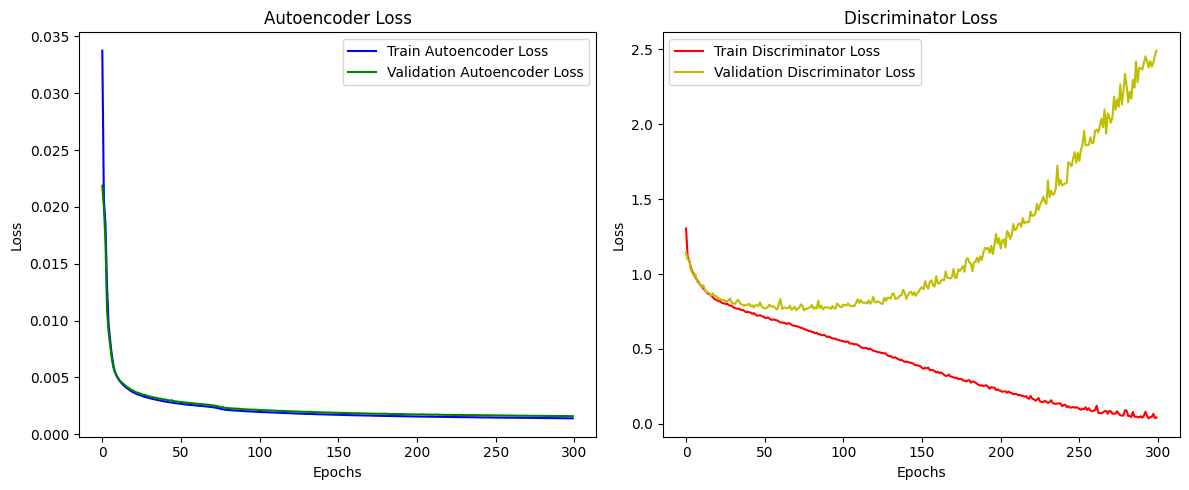

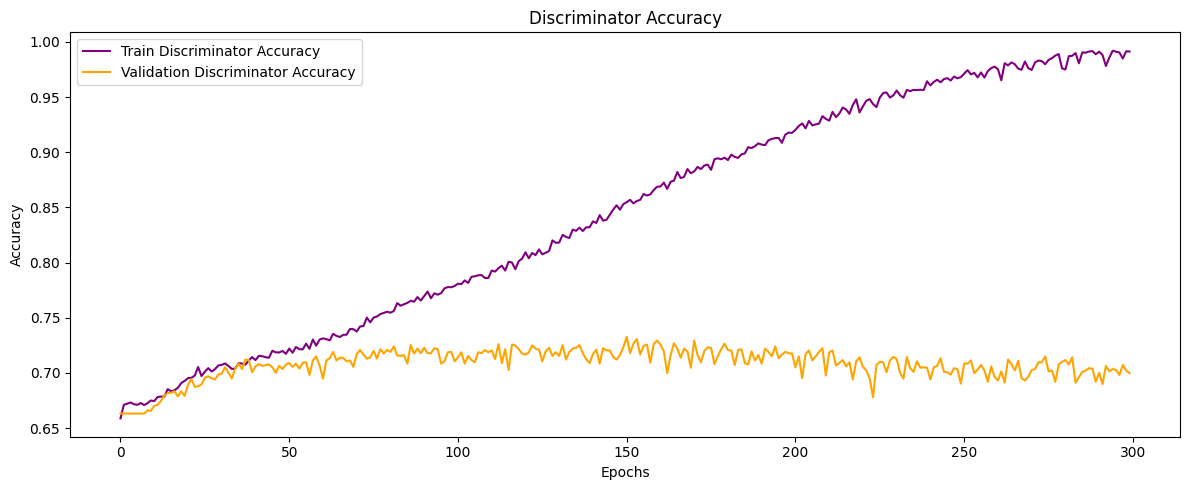

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the loss curves
def plot_loss_curves():
    plt.figure(figsize=(12, 5))

    # Autoencoder loss
    plt.subplot(1, 2, 1)
    plt.plot(autoencoder_losses_epoch, label="Train Autoencoder Loss", color="b")
    plt.plot(val_autoencoder_losses_epoch, label="Validation Autoencoder Loss", color="g")
    plt.title("Autoencoder Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Discriminator loss
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_losses_epoch, label="Train Discriminator Loss", color="r")
    plt.plot(val_discriminator_losses_epoch, label="Validation Discriminator Loss", color="y")
    plt.title("Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot discriminator accuracy
def plot_discriminator_accuracy():
    plt.figure(figsize=(12, 5))

    # Discriminator accuracy
    plt.plot(discriminator_acc_epoch, label="Train Discriminator Accuracy", color="purple")
    plt.plot(val_discriminator_acc_epoch, label="Validation Discriminator Accuracy", color="orange")
    plt.title("Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to display generated images at regular intervals
def visualize_generated_images(epoch, generated_images, save_dir="generated_images"):
    # Save generated image at the end of the epoch
    if epoch % 10 == 0:  # Adjust frequency as needed
        plt.figure(figsize=(10, 10))
        for i in range(9):  # Display 9 images in a grid
            plt.subplot(3, 3, i+1)
            plt.imshow(generated_images[i])  # Assuming images are in 3x28x28 format
            plt.axis('off')
        plt.suptitle(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_dir}/generated_images_epoch_{epoch}.png")
        plt.show()

# Visualize loss and accuracy
plot_loss_curves()
plot_discriminator_accuracy()